# 2. Data Preprocessing

## Table of Contents


| Section                    | Link                                      |
|----------------------------|-------------------------------------------|
| 2.1 Introduction           | [Go to Section](#21-introduction)         |
| 2.2 Import Required Libraries/Functions | [Go to Section](#22-import-required-librariesfunctions) |
| 2.3 Load Data              | [Go to Section](#23-load-data)            |
| 2.4 Data Cleaning          | [Go to Section](#24-data-cleaning)        |
| 2.5 Data Integration       | [Go to Section](#25-data-integration)     |
| 2.6 Feature Engineering    | [Go to Section](#26-feature-engineering)  |
| 2.7 Summary                | [Go to Section](#27-summary)              |
| 2.8 Next Steps             | [Go to Section](#28-next-steps)           |

## 2.1 Introduction

The purpose of this notebook is to preprocess the data that has been acquired in the previous notebook [01_data_acquisition.ipynb](01_data_acquisition.ipynb). Data preprocessing is an essential step to ensure the data's quality, integrity, and readiness for subsequent analysis and modeling. The notebook covers cleaning procedures for four separate dataframes: city_data, country_data, weather_data, and migraine_data. It also involves the integration of these dataframes into a unified dataset suitable for downstream analysis. Following data cleaning, feature engineering will be performed to create new variables that may enhance the model's predictive power. Finally, the dataset will be exported as a CSV file for further analysis in the next notebook [03_data_analysis.ipynb](03_data_analysis.ipynb).

## 2.2 Import Required Libraries/Functions

In the field of data analytics, beginning with the right set of tools is crucial. This section is dedicated to importing the necessary libraries and functions that form the backbone of our data preprocessing efforts. Libraries such as Pandas for data manipulation, NumPy for numerical operations, and others specific to our tasks will be imported here. By centralizing our imports, we ensure that our environment is prepared and that any dependencies are explicitly stated at the outset of our notebook, providing clarity and ease of replication for future analyses.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import missingno as msno

# Load the environment variables
load_dotenv("../config/.env")

# Get the path to the scripts folder
scripts_path = os.getenv("SCRIPTS_PATH")

# Add the path to the scripts folder to the sys.path list
if scripts_path is not None:
    if scripts_path not in sys.path:
        sys.path.append(scripts_path)

# Import functions from the scripts folder
from raw_data import get_raw_dataframes
from data_location_matcher import find_matching_and_non_matching
from data_location_matcher import US_STATES, COUNTRIES
from temp_conversion import *
from wind_conversion import *

# Import functions from libraries
from numpy import diff
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.metrics import mean_absolute_error

# Set the style of the plots
plt.style.use('ggplot')

# Display all the columns
pd.set_option('display.max_columns', None)

# Stop scientific notation and limit to 2 decimal points
pd.set_option('display.float_format', '{:.2f}'.format)

## 2.3 Load Data

The foundation of any data analytics project is the data itself. In this section, we turn our attention to loading the datasets that will be the raw material for our insights. We will meticulously import data from various formats, ensuring that each byte finds its rightful place in our analytical framework. Whether it's CSV files, SQL databases, or direct API feeds, each source will be handled with precision to preserve the integrity of the information. We will also perform initial inspections to assess the structure, size, and completeness of the incoming data, setting us up for the cleaning and integration tasks ahead. The processes outlined here are vital, as they lay the groundwork for the transformative steps that will follow in our data preprocessing pipeline.

In [2]:
# Load data
city_data, country_data, weather_data, migraine_data = get_raw_dataframes()

# Check the shape of the dataframes
city_data.shape, country_data.shape, weather_data.shape, migraine_data.shape

((1245, 8), (214, 11), (27635763, 14), (1377000, 10))

## 2.4 Data Cleaning

### 2.4.1 Overview

In this section, the focus is on preparing the dataset for further analysis and exploration. The steps include cleaning the data by dropping unnecessary columns and rows, filtering the data based on specific criteria, and merging multiple data sources. Each of these steps is essential for ensuring the data's integrity, usability, and relevance to the study objectives.

**Data Cleaning**

Columns that do not contribute to the analysis or contain redundant information are dropped to simplify the dataset. Rows with missing or irrelevant data are removed/imputed to improve the dataset's quality and consistency. Duplicate rows, if any, are identified and removed to ensure each record in the dataset is unique.

**Data Filtering**

The datasets are filtered/aggragated to ensure that only relevant data are included in the analysis. For example, the weather data is aggregated to the year, country, and state level and limited to the years 1990-2019 to match the migraine data's time frame. The migraine data is filtered to include only the relevant columns for the analysis. The city-country data is filtered to include only the countries and states with migraine data.

**Data Merging**

The first step involves merging the city and country datasets using a common identifier. This integration provides a comprehensive view that combines geographical and political attributes. Following that, the weather dataset is integrated with the already combined city-country data. The resulting dataset offers a rich context, incorporating both geographical information and meteorological variables.

---

Throughout these steps, the data are continuously inspected to understand their structures, types, and quality. Various data profiling techniques are employed, such as examining data distributions, checking for missing values, and assessing data types, to ensure that the dataset meets the quality and integrity requirements for downstream analysis.

### 2.4.2 DataFrame: `city_data`

#### 2.4.2.1 Data Consistency Check

- Check if the data is consistent across all columns, i.e., no anomalies or contradictions
- Use .describe() to obtain summary statistics, if appropriate
- Use .info() to get an overview of the dataset

In [3]:
# Check the city data
city_data

,station_id,city_name,country,state,iso2,iso3,latitude,longitude
0,41515,Asadabad,Afghanistan,Kunar,AF,AFG,34.87,71.15
1,38954,Fayzabad,Afghanistan,Badakhshan,AF,AFG,37.13,70.58
2,41560,Jalalabad,Afghanistan,Nangarhar,AF,AFG,34.44,70.44
3,38947,Kunduz,Afghanistan,Kunduz,AF,AFG,36.73,68.87
4,38987,Qala i Naw,Afghanistan,Badghis,AF,AFG,34.98,63.13
...,...,...,...,...,...,...,...,...
1240,67475,Kasama,Zambia,Northern,ZM,ZMB,-10.20,31.18
1241,68030,Livingstone,Zambia,Southern,ZM,ZMB,-17.86,25.86
1242,67633,Mongu,Zambia,Western,ZM,ZMB,-15.28,23.12
1243,67775,Harare,Zimbabwe,Harare,ZW,ZWE,-17.82,31.04


In [4]:
# Get overview of the data
city_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1245 entries, 0 to 1244
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   station_id  1245 non-null   object 
 1   city_name   1244 non-null   object 
 2   country     1245 non-null   object 
 3   state       1217 non-null   object 
 4   iso2        1239 non-null   object 
 5   iso3        1245 non-null   object 
 6   latitude    1245 non-null   float64
 7   longitude   1245 non-null   float64
dtypes: float64(2), object(6)
memory usage: 77.9+ KB


#### 2.4.2.2 Initial Review for Missing and Zero Values

In [5]:
# Check for missing values
print("\nCity Missing Values:")
print(city_data.isnull().sum())

# Calculate zero counts for each column
print("\nCity Zero Counts:")
zero_counts = (city_data == 0).sum()
print(zero_counts)


City Missing Values:
station_id     0
city_name      1
country        0
state         28
iso2           6
iso3           0
latitude       0
longitude      0
dtype: int64

City Zero Counts:
station_id    0
city_name     0
country       0
state         0
iso2          0
iso3          0
latitude      0
longitude     0
dtype: int64


No zero counts were found in the dataset. However, there are missing values in the following columns:
- `city_name`: 1
- `state`: 28
- `iso2`: 6

In [6]:
# Review data where the `city_name` is missing
city_data[city_data['city_name'].isnull()]

,station_id,city_name,country,state,iso2,iso3,latitude,longitude
911,40360,NaN,Saudi Arabia,Al Jawf,SA,SAU,31.33,37.33


Utilizing maps and Google search, the missing `city_name` was identified as `Al Qurayyat` [maps.google.com](https://www.google.com/maps/place/31%C2%B019'59.9%22N+37%C2%B019'59.9%22E/@31.3333066,37.3307221,17z/data=!4m4!3m3!8m2!3d31.333302!4d37.333297?entry=ttu). The missing value was manually added to the dataframe.

In [7]:
# Add the mising city name for index row 911
city_data.loc[911, 'city_name'] = 'Al Qurayyat'

In [8]:
# Review data where the state is null/missing
city_data[city_data['state'].isnull()]

,station_id,city_name,country,state,iso2,iso3,latitude,longitude
36,91765,Pago Pago,American Samoa,NaN,AS,ASM,-14.28,-170.71
37,07627,Andorra la Vella,Andorra,NaN,AD,AND,42.50,1.52
92,41150,Manama,Bahrain,NaN,BH,BHR,26.24,50.58
110,78016,Hamilton,Bermuda,NaN,BM,BMU,32.29,-64.78
169,08589,Praia,Cape Verde,NaN,CV,CPV,14.92,-23.52
170,78384,George Town,Cayman Islands,NaN,KY,CYM,19.28,-81.33
234,80001,San Andrés,Colombia,NaN,CO,COL,12.56,-81.69
248,91843,Avarua,Cook Islands,NaN,CK,COK,-21.25,-159.75
294,88889,Stanley,Falkland Islands,NaN,FK,FLK,-51.70,-57.85
328,91938,Papeete,French Polynesia,NaN,PF,PYF,-17.53,-149.57


The missing state values are for non-US countries and will be changed to 'Non-US' in a later step.

In [9]:
# Review data where iso2 is null/missing
city_data[city_data['iso2'].isnull()]

,station_id,city_name,country,state,iso2,iso3,latitude,longitude
682,68116,Gobabis,Namibia,Omaheke,NaN,NAM,-22.45,18.96
683,68312,Keetmanshoop,Namibia,Karas,NaN,NAM,-26.57,18.13
684,68114,Omaruru,Namibia,Erongo,NaN,NAM,-21.44,15.95
685,68098,Swakopmund,Namibia,Erongo,NaN,NAM,-22.67,14.54
686,68014,Tsumeb,Namibia,Oshikoto,NaN,NAM,-19.24,17.71
687,68110,Windhoek,Namibia,Khomas,NaN,NAM,-22.57,17.08


The iso2 column will be dropped as it is not relevant to the analysis.

In [10]:
city_data.isnull().sum()

station_id     0
city_name      0
country        0
state         28
iso2           6
iso3           0
latitude       0
longitude      0
dtype: int64

#### 2.4.2.3 Drop Unnecessary Columns/Rows

Drop columns or rows that are not needed for the analysis based on the project's scope.

The iso2 column is dropped as it is not relevant to the analysis. No rows are dropped at this time.

In [11]:
# Drop the iso2 column
city_data.drop(columns=['iso2'], inplace=True)

#### 2.4.2.4 Rename Columns

Rename columns to have meaningful names and to follow a consistent naming convention.

Renaming the `city_name` column to `city` to match the naming convention of the other dataframes.

In [12]:
# Rename the city_name column to city
city_data.rename(columns={'city_name': 'city'}, inplace=True)

# confirm changes
city_data.head()

,station_id,city,country,state,iso3,latitude,longitude
0,41515,Asadabad,Afghanistan,Kunar,AFG,34.87,71.15
1,38954,Fayzabad,Afghanistan,Badakhshan,AFG,37.13,70.58
2,41560,Jalalabad,Afghanistan,Nangarhar,AFG,34.44,70.44
3,38947,Kunduz,Afghanistan,Kunduz,AFG,36.73,68.87
4,38987,Qala i Naw,Afghanistan,Badghis,AFG,34.98,63.13


#### 2.4.2.5 Standardizing Text Data

Standardize `country` and `state` names, matching to a standardized list of countries and states retreived from [The Weather Dataset](https://www.kaggle.com/datasets/guillemservera/global-daily-climate-data/) found on kaggle site.

##### 2.4.2.5.1 Standardize `country` Names

In [13]:
# Find matching and non-matching countries
city_data_matching_countries, city_data_non_matching_countries = find_matching_and_non_matching(city_data, 'country')

# View the non-matching countries
city_data_non_matching_countries

{'Bahamas',
 'Barbados',
 'Cabo Verde',
 "Cote d'Ivoire",
 'Czechia',
 'Eritrea',
 'Eswatini',
 'Gambia',
 'Guinea-Bissau',
 'Kosovo',
 'Micronesia',
 'Nauru',
 'Palau',
 'Palestine',
 'Panama',
 'Saint Lucia',
 'Saint Vincent and the Grenadines',
 'Sao Tome and Principe',
 'Timor-Leste',
 'Tonga',
 'Vatican City'}

In [14]:
# Create a dictionary of country name replacements
city_data_country_replacement_dict = { 
    'Guinea Bissau': 'Guinea-Bissau',
    'Korea, North': 'North Korea',
    'Korea, South': 'South Korea',
    'Macau S.A.R': 'Macau',
    'Svalbard and Jan Mayen Islands': 'Svalbard and Jan Mayen',
    'São Tomé and Príncipe': 'Sao Tome and Principe',
    'The Bahamas': 'Bahamas',
    'The Gambia': 'Gambia',
    'United States': 'United States of America'
}

# Replace the country names in the city dataframe
city_data['country'].replace(city_data_country_replacement_dict, inplace=True)

# Confirm the changes
city_data['country'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'American Samoa', 'Andorra',
       'Angola', 'Anguilla', 'Antigua and Barbuda', 'Argentina',
       'Armenia', 'Aruba', 'Australia', 'Austria', 'Azerbaijan',
       'Bahrain', 'Bangladesh', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina',
       'Botswana', 'Brazil', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Christmas Island', 'Colombia', 'Comoros',
       'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Cook Islands',
       'Costa Rica', 'Croatia', 'Cuba', 'Cyprus', 'Czech Republic',
       'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic',
       'East Timor', 'Ecuador', 'Egypt', 'El Salvador',
       'Equatorial Guinea', 'Estonia', 'Ethiopia', 'Falkland Islands',
       'Fiji', 'Finland', 'France', 'French Guiana', 'French Polynesia',

##### 2.4.2.5.2 Standardize `state` Names

In [15]:
# Find matching and non-matching states
city_data_matching_states, city_data_non_matching_states = find_matching_and_non_matching(city_data, 'state')

# View the non-matching states
city_data_non_matching_states

{'Louisiana', 'South Dakota'}

In [16]:
# Review state names
city_data['state'].unique()

array(['Kunar', 'Badakhshan', 'Nangarhar', ..., 'Southern', 'Harare',
       'Masvingo'], dtype=object)

In [17]:
# Check state values in the city data, if not US state, replace with 'Non-US'
city_data['state'] = city_data['state'].apply(lambda x: x if x in US_STATES else 'Non-US')

# Confirm the changes
city_data['state'].unique()

array(['Non-US', 'Montana', 'Maryland', 'New York', 'Georgia', 'Maine',
       'Texas', 'North Dakota', 'Idaho', 'Massachusetts', 'Nevada',
       'West Virginia', 'Wyoming', 'South Carolina', 'Ohio',
       'New Hampshire', 'Colorado', 'Iowa', 'Delaware', 'Kentucky',
       'Pennsylvania', 'Connecticut', 'Hawaii', 'Indiana', 'Mississippi',
       'Missouri', 'Alaska', 'Michigan', 'Nebraska', 'Arkansas',
       'Wisconsin', 'Alabama', 'Vermont', 'Tennessee', 'Oklahoma',
       'Washington', 'Arizona', 'Rhode Island', 'North Carolina',
       'Virginia', 'California', 'Minnesota', 'Oregon', 'Utah',
       'New Mexico', 'Illinois', 'Florida', 'Kansas', 'New Jersey',
       'District of Columbia'], dtype=object)

#### 2.4.2.6 Merging with Other Datasets

Not merging/joining the city_data DataFrame with relevant datasets like country_data at this stage. Will do this step after the country_data DataFrame has been cleaned/standardized.

#### 2.4.2.7 Data Type Conversion

Convert columns to the appropriate data type (float, integer, string, datetime, etc.).

In [18]:
city_data.dtypes

station_id     object
city           object
country        object
state          object
iso3           object
latitude      float64
longitude     float64
dtype: object

All data types are appropriate for the columns.

#### 2.4.2.8 Handling Categorical Variables

Label encode or one-hot encode categorical variables as needed.

Given the specific goal of this analysis, we will not convert the geographic identifiers like city, country, and state into numerical formats through encoding. These variables serve as identifiers for the analysis, especially since we'll be using latitude and longitude for map visualizations. Converting into numerical categories could make the data less interpretable and complicate the visualization process.

Moreover, since we are interested in analyzing the number of migraines occurring in relation to sea-level pressure variations in specific geographical areas, keeping the geographic locations as categorical variables will make it easier to slice and dice the data. This will allow filtering or grouping of the data based on these geographical identifiers to derive more localized insights.

#### 2.4.2.9 Outliers Detection and Treatment

In the context of geographic data, the concept of "outliers" for latitude and longitude is generally not applicable in the traditional statistical sense. Latitudes range from -90 to 90, and longitudes range from -180 to 180. Any data point within these ranges is valid unless it doesn't make sense in this specific study (e.g., interested in a specific region but have coordinates from outside that region).

For geographical data, what could be considered an "outlier" might actually be more of a data entry error or a misplaced coordinate that could misrepresent the location. For example, a latitude and longitude that point to a location in the ocean for what is supposed to be a city would be an "outlier" in the context of analysis.

Rather than looking for outliers in the statistical sense, we want to validate the geographic data to ensure that the coordinates actually correspond to the cities they are supposed to represent. This can be done by plotting the coordinates on a map and checking for any points that seem out of place, given the context of the study.

In [19]:
# Create a base map
m = folium.Map(location=[20, 0], zoom_start=3)

# Add points to the map
for idx, row in city_data.iterrows():
    folium.CircleMarker(location=[row['latitude'], row['longitude']], 
                        radius=5, 
                        color='blue', 
                        fill=True, 
                        fill_color='blue').add_to(m).add_child(folium.Popup(f"City: {row['city']}, Country: {row['country']}"))

# Show the map
m

#### 2.4.2.10 Secondary Review for Missing and Zero Values

Conduct a second review for missing values.
Decide on an imputation strategy for each column with missing values.

In [20]:
# Check for missing values
city_data.isnull().sum()

station_id    0
city          0
country       0
state         0
iso3          0
latitude      0
longitude     0
dtype: int64

In [21]:
# Check for zero values
(city_data == 0).sum()

station_id    0
city          0
country       0
state         0
iso3          0
latitude      0
longitude     0
dtype: int64

Standardizing the `country` and `state` names resulted in the missing values for these columns being filled in with 'Non-US'. This is an appropriate value for the `state` column since the missing values are for non-US countries.

#### 2.4.2.11 Replacing Missing Values

No missing values to replace.

#### 2.4.2.12 Data Transformation

Normalize or standardize numerical columns if needed.
Log transformation for skewed data.

In the context of this specific analysis, the numerical variables present in the city_data DataFrame are latitude and longitude, which are geographic coordinates. Traditional data transformation techniques like normalization, standardization, or log transformation are generally not applied to such variables, as they would distort their geographic meaning. These coordinates are used as-is for mapping and geographic filtering, so we will not perform any transformations on them in this analysis.

#### 2.4.2.13 Checking and Removing Duplicates

Use .duplicated() to check for duplicate rows and .drop_duplicates() to remove them.

In [22]:
# Check for duplicates
city_data.duplicated().sum()

0

#### 2.4.2.14 Summary for Data Cleaning Steps for `city_data`

In this section, we've rigorously cleaned the `city_data` DataFrame to enhance its quality and usability. Below is a succinct summary:

1. **Data Consistency**: Verified column-wise consistency; flagged missing values for further review.
  
2. **Missing/Zero Values**: Filled in or flagged missing values; primarily affected non-U.S. entries.
  
3. **Column/Row Pruning**: Removed irrelevant columns and rows for a focused analysis. _(Details pending)_

4. **Column Renaming**: Aligned column names for better readability.

5. **Text Standardization**: Harmonized country and state names across datasets, employing custom functions and dictionaries for transformation.

6. **Data Merging**: Deferred merging with `country_data` until it undergoes similar cleaning.

7. **Data Types**: Confirmed all data types are suitable for analysis.

8. **Categorical Variables**: Chose not to encode geographic identifiers to preserve interpretability.

9. **Outlier Management**: Validated geographic coordinates via map plotting; no statistical outliers.

10. **Second Missing Value Review**: Revisited missing values; mostly resolved through text standardization.

11. **Missing Value Replacement**: No missing values left to replace.

12. **Data Transformation**: Preserved latitude and longitude data in their original form for geographic fidelity.

13. **Duplicate Handling**: Confirmed no duplicate entries exist.

The cleaning steps have readied `city_data` for future stages of integration, feature engineering, and modeling. Similar methodologies will be applied to the remaining DataFrames: `country_data`, `weather_data`, and `migraine_data`.

##### 2.4.2.15 Export the Cleaned City Data

In [23]:
# Export the processed city data
city_data.to_csv('../data/processed/city_data.csv', index=False)

### 2.4.3 DataFrame: `country_data`

#### 2.4.3.1 Data Consistency Check

- Check if the data is consistent across all columns, i.e., no anomalies or contradictions
- Use .describe() to obtain summary statistics, if appropriate
- Use .info() to get an overview of the dataset

In [24]:
# Check the country data
country_data

,country,native_name,iso2,iso3,population,area,capital,capital_lat,capital_lng,region,continent
0,Afghanistan,افغانستان,AF,AFG,26023100.00,652230.00,Kabul,34.53,69.18,Southern and Central Asia,Asia
1,Albania,Shqipëria,AL,ALB,2895947.00,28748.00,Tirana,41.33,19.82,Southern Europe,Europe
2,Algeria,الجزائر,DZ,DZA,38700000.00,2381741.00,Algiers,36.78,3.06,Northern Africa,Africa
3,American Samoa,American Samoa,AS,ASM,55519.00,199.00,Pago Pago,-14.28,-170.70,Polynesia,Oceania
4,Angola,Angola,AO,AGO,24383301.00,1246700.00,Luanda,-8.83,13.24,Central Africa,Africa
...,...,...,...,...,...,...,...,...,...,...,...
209,Wallis and Futuna,Wallis et Futuna,WF,WLF,13135.00,142.00,Mata-Utu,-13.28,-176.17,Polynesia,Oceania
210,Western Sahara,الصحراء الغربية,EH,ESH,586000.00,266000.00,El Aaiún,27.15,-13.20,Northern Africa,Africa
211,Yemen,اليَمَن,YE,YEM,25956000.00,527968.00,Sana'a,15.35,44.21,Middle East,Asia
212,Zambia,Zambia,ZM,ZMB,15023315.00,752612.00,Lusaka,-15.42,28.28,Eastern Africa,Europe


In [25]:
country_data.describe()

,population,area,capital_lat,capital_lng
count,210.00,207.00,212.00,212.00
mean,33651437.96,653760.38,18.81,16.55
std,133046144.66,1866908.64,26.59,69.63
min,30.00,2.02,-54.28,-176.17
25%,757260.50,13066.00,2.87,-13.38
50%,6315500.00,109884.00,18.03,16.73
75%,22683784.75,481771.00,41.32,47.64
max,1367110000.00,17124442.00,78.22,179.12


** Population **

- **Count**: There are 210 countries (or rows) with population data.
- **Mean**: The average population is approximately 33,651,438.
- **Standard Deviation**: The standard deviation of about 133,046,145 suggests a wide dispersion or variability in the population data.
- **Min**: The smallest population among these countries is just 30.
- **25th Percentile**: 25% of the countries have a population less than or equal to approximately 757,260.
- **Median**: The median population, or the 50th percentile, is approximately 6,315,500.
- **75th Percentile**: 75% of the countries have a population less than or equal to approximately 22,683,785.
- **Max**: The largest population is 1,367,110,000, which is likely to be China, considering current global demographics.

** Area **

- **Count**: All 207 countries also have area data.
- **Mean**: The average area is about 653,760 square kilometers.
- **Standard Deviation**: The standard deviation of about 1,866,909 suggests there's a large variation in country sizes.
- **Min**: The smallest country has an area of just 2.02 square kilometers.
- **25th Percentile**: 25% of countries have an area less than or equal to approximately 13,066 square kilometers.
- **Median**: The median area, or the 50th percentile, is approximately 109,884 square kilometers.
- **75th Percentile**: 75% of countries have an area less than or equal to approximately 481,771 square kilometers.
- **Max**: The largest country has an area of 17,124,442 square kilometers, likely Russia.

`capital_lat` and `capital_lng` columns are not relevant to the analysis and will be dropped.

** Key Insights **

- **Skewness**: Both population and area data are likely highly skewed, given the large difference between the mean and median, as well as the wide range between the minimum and maximum values.
- **Variability**: The high standard deviation in both cases indicates significant variability among countries in terms of both population and area.
- **Scale**: The data spans multiple orders of magnitude, from countries with populations as low as 30 to as high as over a billion, and from countries as small as 2 square kilometers to as large as millions of square kilometers.

In [26]:
country_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      214 non-null    object 
 1   native_name  213 non-null    object 
 2   iso2         213 non-null    object 
 3   iso3         214 non-null    object 
 4   population   210 non-null    float64
 5   area         207 non-null    float64
 6   capital      212 non-null    object 
 7   capital_lat  212 non-null    float64
 8   capital_lng  212 non-null    float64
 9   region       205 non-null    object 
 10  continent    206 non-null    object 
dtypes: float64(4), object(7)
memory usage: 18.5+ KB


** General Information **

- **Type of Object**: Pandas DataFrame
- **Row Details**: 214 rows indexed from 0 to 213

** Column Details **

- **Total Columns**: 11 columns

** Column-wise Information **

1. **`country`:** 
  - **Non-Null Count**: 214
  - **Data Type**: Object (typically used for text)
2. **`native_name`:** 
  - **Non-Null Count**: 213
  - **Data Type**: Object (typically used for text)
3. **`iso2`:** 
  - **Non-Null Count**: 213
  - **Data Type**: Object
4. **`iso3`:** 
  - **Non-Null Count**: 214
  - **Data Type**: Object
5. **`population`:** 
  - **Non-Null Count**: 210
  - **Data Type**: Float64 (used for numerical data)
6. **`area`:** 
  - **Non-Null Count**: 207
  - **Data Type**: Float64
7. **`capital`:** 
  - **Non-Null Count**: 212
  - **Data Type**: Object (typically used for text)
8. **`capital_lat`:** 
  - **Non-Null Count**: 212
  - **Data Type**: Float64 (used for numerical data)
9. **`capital_lng`:** 
  - **Non-Null Count**: 212
  - **Data Type**: Float64
10. **`region`:** 
  - **Non-Null Count**: 205
  - **Data Type**: Object (typically used for text)
11. **`continent`:** 
  - **Non-Null Count**: 206
  - **Data Type**: Object

** Memory Usage **

- **Memory**: Approximately 18.5+ KB

** Key Takeaways **

1. **Complete Data**: `country` and `iso3` columns have 214 non-null entries, indicating no missing values. The remaining columns have a few missing values, which will be addressed in the next section.
2. **Data Types**: Four numerical columns (`population`, `area`, `capital_lat`, `capital_lng`) and seven text-based columns (`country`, `native_name` `iso2`, `iso3`, `capital`, `region`, `continent`).
3. **Memory Efficient**: Relatively small memory footprint of about 18.5 KB.

#### 2.4.3.2 Initial Review for Missing and Zero Values

Conduct an initial review for missing values using .isna().sum() and for zero values.

In [27]:
# Check for missing values
print("\nCountry Missing Values:")
print(country_data.isnull().sum())

# Calculate zero counts for each column
print("\nCountry Zero Counts:")
zero_counts = (country_data == 0).sum()
print(zero_counts)


Country Missing Values:
country        0
native_name    1
iso2           1
iso3           0
population     4
area           7
capital        2
capital_lat    2
capital_lng    2
region         9
continent      8
dtype: int64

Country Zero Counts:
country        0
native_name    0
iso2           0
iso3           0
population     0
area           0
capital        0
capital_lat    0
capital_lng    0
region         0
continent      0
dtype: int64


No zero counts were found in the dataset. However, there are missing values in the following columns:
- `native_name`: 1
- `iso2`: 1
- `population`: 4
- `area`: 7
- `capital`: 2
- `capital_lat`: 2
- `capital_lng`: 2
- `region`: 9
- `continent`: 8

In [28]:
# Review data where the `native_name` is missing
country_data[country_data['native_name'].isnull()]

,country,native_name,iso2,iso3,population,area,capital,capital_lat,capital_lng,region,continent
208,Wales,NaN,GB,GBR,NaN,NaN,NaN,NaN,NaN,NaN,Europe


Located the `native_name` for the country Wales (from [Wales | About](https://www.wales.com/about/language/place-names-wales#:~:text=The%20Welsh%20name%20for%20Wales,'a%20fellow%2Dcountryman'.) ) and filled in manually.

In [29]:
# Add the mising native_name for index row 208
country_data.loc[208, 'native_name'] = 'Cymru'

# Review data just added
country_data.loc[208, :]

country         Wales
native_name     Cymru
iso2               GB
iso3              GBR
population        NaN
area              NaN
capital           NaN
capital_lat       NaN
capital_lng       NaN
region            NaN
continent      Europe
Name: 208, dtype: object

In [30]:
# Review data where the `iso2` is missing
country_data[country_data['iso2'].isnull()]

,country,native_name,iso2,iso3,population,area,capital,capital_lat,capital_lng,region,continent
131,Namibia,Namibia,NaN,NAM,2113077.00,825615.00,Windhoek,-22.57,17.08,Southern Africa,Africa


As in the `city_data` dataframe, the `iso2` column will be dropped as it is not relevant to the analysis so missing values will not be addressed.

In [31]:
country_data.isnull().sum()

country        0
native_name    0
iso2           1
iso3           0
population     4
area           7
capital        2
capital_lat    2
capital_lng    2
region         9
continent      8
dtype: int64

In [32]:
# Review data where the `population` is missing
country_data[country_data['population'].isnull()]

,country,native_name,iso2,iso3,population,area,capital,capital_lat,capital_lng,region,continent
10,Australia,Australia,AU,AUS,NaN,7692024.00,Canberra,-35.30,149.10,Australia and New Zealand,Oceania
66,Gabon,Gabon,GA,GAB,NaN,267668.00,Libreville,0.39,9.45,Central Africa,Africa
71,Greece,Ελλάδα,GR,GRC,NaN,131990.00,Athens,37.98,23.73,Southern Europe,Europe
208,Wales,Cymru,GB,GBR,NaN,NaN,NaN,NaN,NaN,NaN,Europe


Located the appropriate `population` values for the missing countries, (from [Worldometers](https://www.worldometers.info/world-population/population-by-country/)) and filled in manually. The information on 'Wales' was not available, but found its information on [Facts about Wales](https://www.wales.com/en-us/about/facts-about-wales) and filled in manually.

- 'Australia': population = 26,439,111
- 'Gabon': population = 2,436,566
- 'Greece': population = 10,341,277
- 'Wales': population = 3,135,000
- 'Wales': area = 20,779 km2
- 'Wales': region = Northern Europe

In [33]:
# Add the missing population value for index 10, 66, 71, and 208
country_data.loc[10, 'population'] = 26439111
country_data.loc[66, 'population'] = 2436566
country_data.loc[71, 'population'] = 10341277
country_data.loc[208, 'population'] = 3135000

# Add the missing area, capital and region values for index 208
country_data.loc[208, 'area'] = 20779
country_data.loc[208, 'region'] = 'Northern Europe'

# Review data just added
print("\nCountry Data for index 10, 66, 71, and 208:")
country_data.loc[[10, 66, 71, 208], :]


Country Data for index 10, 66, 71, and 208:


,country,native_name,iso2,iso3,population,area,capital,capital_lat,capital_lng,region,continent
10,Australia,Australia,AU,AUS,26439111.00,7692024.00,Canberra,-35.30,149.10,Australia and New Zealand,Oceania
66,Gabon,Gabon,GA,GAB,2436566.00,267668.00,Libreville,0.39,9.45,Central Africa,Africa
71,Greece,Ελλάδα,GR,GRC,10341277.00,131990.00,Athens,37.98,23.73,Southern Europe,Europe
208,Wales,Cymru,GB,GBR,3135000.00,20779.00,NaN,NaN,NaN,Northern Europe,Europe


In [34]:
country_data.isnull().sum()

country        0
native_name    0
iso2           1
iso3           0
population     0
area           6
capital        2
capital_lat    2
capital_lng    2
region         8
continent      8
dtype: int64

In [35]:
# Review data where the `area` is missing
country_data[country_data['area'].isnull()]

,country,native_name,iso2,iso3,population,area,capital,capital_lat,capital_lng,region,continent
63,French Guiana,Guyane française,GF,GUF,237549.00,NaN,Cayenne,4.94,-52.33,South America,South America
123,Mayotte,Mayotte,YT,MYT,212645.00,NaN,Mamoudzou,-12.78,45.23,Eastern Africa,Africa
156,Réunion,La Réunion,RE,REU,840974.00,NaN,Saint-Denis,48.94,2.36,Eastern Africa,Africa
157,Saint Helena,Saint Helena,SH,SHN,4255.00,NaN,Jamestown,37.21,-76.77,Western Africa,Africa
173,South Georgia,South Georgia,GS,SGS,30.00,NaN,King Edward Point,-54.28,-36.49,Antarctica,Antarctica
180,Svalbard and Jan Mayen,Svalbard og Jan Mayen,SJ,SJM,2562.00,NaN,Longyearbyen,78.22,15.65,Nordic Countries,Europe


Located the appropriate `area` values for the missing countries, (from [Worldometers](https://www.worldometers.info/world-population/population-by-country/)) and filled in manually. The information on 'Svalbard and Jan Mayen' was not available, but found its information on [AllCountries.eu](https://www.allcountries.eu/svalbard-jan-mayen.htm) and filled in manually.

In [36]:
# Add the missing area values for index 63, 123, 156, 157, 173, and 180
country_data.loc[63, 'area'] = 82200
country_data.loc[123, 'area'] = 375
country_data.loc[156, 'area'] = 2500
country_data.loc[157, 'area'] = 390
country_data.loc[173, 'area'] = 3756
country_data.loc[180, 'area'] = 62049

# Review data just added
print("\nCountry Data for index 63, 123, 156, 157, 173, and 180:")
country_data.loc[[63, 123, 156, 157, 173, 180], :]


Country Data for index 63, 123, 156, 157, 173, and 180:


,country,native_name,iso2,iso3,population,area,capital,capital_lat,capital_lng,region,continent
63,French Guiana,Guyane française,GF,GUF,237549.00,82200.00,Cayenne,4.94,-52.33,South America,South America
123,Mayotte,Mayotte,YT,MYT,212645.00,375.00,Mamoudzou,-12.78,45.23,Eastern Africa,Africa
156,Réunion,La Réunion,RE,REU,840974.00,2500.00,Saint-Denis,48.94,2.36,Eastern Africa,Africa
157,Saint Helena,Saint Helena,SH,SHN,4255.00,390.00,Jamestown,37.21,-76.77,Western Africa,Africa
173,South Georgia,South Georgia,GS,SGS,30.00,3756.00,King Edward Point,-54.28,-36.49,Antarctica,Antarctica
180,Svalbard and Jan Mayen,Svalbard og Jan Mayen,SJ,SJM,2562.00,62049.00,Longyearbyen,78.22,15.65,Nordic Countries,Europe


In [37]:
country_data.isnull().sum()

country        0
native_name    0
iso2           1
iso3           0
population     0
area           0
capital        2
capital_lat    2
capital_lng    2
region         8
continent      8
dtype: int64

The `capital`, `capital_lat`, and `capital_lng` columns will be dropped as they are not relevant to the analysis so missing values will not be addressed.

In [38]:
# Review data where the `region` is missing
country_data[country_data['region'].isnull()]

,country,native_name,iso2,iso3,population,area,capital,capital_lat,capital_lng,region,continent
47,Democratic Republic of the Congo,République démocratique du Congo,CD,COD,69360000.00,2344858.00,Kinshasa,-4.32,15.31,NaN,NaN
70,Gibraltar,Gibraltar,GI,GIB,30001.00,6.00,Gibraltar,36.14,-5.35,NaN,NaN
76,Guernsey,Guernsey,GG,GGY,63085.00,78.00,St. Peter Port,49.46,-2.54,NaN,NaN
90,Isle of Man,Isle of Man,IM,IMN,84497.00,572.00,Douglas,39.76,-88.22,NaN,NaN
93,Ivory Coast,Côte d'Ivoire,CI,CIV,23821000.00,322463.00,Yamoussoukro,6.81,-5.27,NaN,NaN
96,Jersey,Jersey,JE,JEY,99000.00,116.00,Saint Helier,47.38,4.68,NaN,NaN
164,Serbia,Srbija,RS,SRB,7186862.00,49037.00,Belgrade,44.82,20.46,NaN,NaN
186,Taiwan,臺灣,TW,TWN,23424615.00,36193.00,Taipei,25.04,121.56,NaN,NaN


Located the appropriate `region` and `continent` values for the 8 countries below, (from [Worldometers](https://www.worldometers.info/world-population/population-by-country/)) and filled in manually.
- `Democratic Republic of the Congo`: region = Central Africa, continent = Africa
- `Gibraltar`: region = Southern Europe, continent = Europe
- `Guernsey`: region = Northern Europe, continent = Europe
- `Isle of Man`: region = Northern Europe, continent = Europe
- `Ivory Coast`: region = Western Africa, continent = Africa
- `Jersey`: region = Northern Europe, continent = Europe
- `Serbia`: region = Southern Europe, continent = Europe
- `Taiwan`: region = Eastern Asia, continent = Asia


In [39]:
# Add the missing region and continent values for index 47, 70, 76, 90, 93, 96, 164, and 186

# Creating update dictionaries for each column
update_region = {47: 'Central Africa', 70: 'Southern Europe', 76: 'Northern Europe',\
                  90: 'Northern Europe', 93: 'Western Africa', 96: 'Northern Europe', 164: 'Southern Europe', 186: 'Eastern Asia'}
update_continent = {47: 'Africa', 70: 'Europe', 76: 'Europe', 90: 'Europe', 93: 'Africa', 96: 'Europe', 164: 'Europe', 186: 'Asia'}

# Updating the DataFrame using `map` and dictionary
country_data['region'] = country_data.index.map(lambda x: update_region.get(x, country_data.loc[x, 'region']))
country_data['continent'] = country_data.index.map(lambda x: update_continent.get(x, country_data.loc[x, 'continent']))

# Displaying the updated DataFrame
country_data.loc[[47, 70, 76, 90, 93, 96, 164, 186], :]

,country,native_name,iso2,iso3,population,area,capital,capital_lat,capital_lng,region,continent
47,Democratic Republic of the Congo,République démocratique du Congo,CD,COD,69360000.00,2344858.00,Kinshasa,-4.32,15.31,Central Africa,Africa
70,Gibraltar,Gibraltar,GI,GIB,30001.00,6.00,Gibraltar,36.14,-5.35,Southern Europe,Europe
76,Guernsey,Guernsey,GG,GGY,63085.00,78.00,St. Peter Port,49.46,-2.54,Northern Europe,Europe
90,Isle of Man,Isle of Man,IM,IMN,84497.00,572.00,Douglas,39.76,-88.22,Northern Europe,Europe
93,Ivory Coast,Côte d'Ivoire,CI,CIV,23821000.00,322463.00,Yamoussoukro,6.81,-5.27,Western Africa,Africa
96,Jersey,Jersey,JE,JEY,99000.00,116.00,Saint Helier,47.38,4.68,Northern Europe,Europe
164,Serbia,Srbija,RS,SRB,7186862.00,49037.00,Belgrade,44.82,20.46,Southern Europe,Europe
186,Taiwan,臺灣,TW,TWN,23424615.00,36193.00,Taipei,25.04,121.56,Eastern Asia,Asia


In [40]:
country_data.isnull().sum()

country        0
native_name    0
iso2           1
iso3           0
population     0
area           0
capital        2
capital_lat    2
capital_lng    2
region         0
continent      0
dtype: int64

#### 2.4.3.3 Drop Unnecessary Columns/Rows

Drop columns or rows that are not needed for the analysis based on the project's scope.

*Keeping* the following columns:
- 'country'
- 'iso3'
- 'population'
- 'area'
- 'region'
- 'continent'

*Removing* the following columns:
- 'native_name'
- 'iso2'
- 'capital'
- 'capital_lat'
- 'capital_lng'

In [41]:
# Drop columns that are not needed
country_data.drop(columns=['native_name', 'iso2', 'capital', 'capital_lat', 'capital_lng'], inplace=True)

# Confirm the changes
country_data.head()

,country,iso3,population,area,region,continent
0,Afghanistan,AFG,26023100.00,652230.00,Southern and Central Asia,Asia
1,Albania,ALB,2895947.00,28748.00,Southern Europe,Europe
2,Algeria,DZA,38700000.00,2381741.00,Northern Africa,Africa
3,American Samoa,ASM,55519.00,199.00,Polynesia,Oceania
4,Angola,AGO,24383301.00,1246700.00,Central Africa,Africa


In [42]:
country_data.isna().sum()

country       0
iso3          0
population    0
area          0
region        0
continent     0
dtype: int64

#### 2.4.3.4 Rename Columns

Rename columns to have meaningful names and to follow a consistent naming convention.

No renaming needed.

#### 2.4.3.5 Standardizing Text Data

Standardize country names, state names, and other text-based fields to ensure uniformity.
Use .str.lower() or .str.upper() to standardize text.

##### 2.4.3.5.1 Standardize `country` Names

In [43]:
# Find matching and non-matching countries
country_data_matching_countries, country_data_non_matching_countries = find_matching_and_non_matching(country_data, 'country')

# View the non-matching countries
country_data_non_matching_countries

{'Andorra',
 'Bahamas',
 'Barbados',
 'Cabo Verde',
 'Congo (Brazzaville)',
 'Congo (Kinshasa)',
 "Cote d'Ivoire",
 'Czechia',
 'Eritrea',
 'Eswatini',
 'Gambia',
 'Kosovo',
 'Micronesia',
 'Montenegro',
 'Myanmar',
 'Nauru',
 'Palau',
 'Palestine',
 'Panama',
 'Saint Lucia',
 'Saint Vincent and the Grenadines',
 'Sao Tome and Principe',
 'Timor-Leste',
 'Tonga',
 'United States of America',
 'Vatican City'}

In [44]:
country_data_country_replacement_dict = {
    'Democratic Republic of the Congo': 'Congo (Kinshasa)',
    'Republic of the Congo': 'Congo (Brazzaville)',
    'Korea, North': 'North Korea',
    'Korea, South': 'South Korea',
    'São Tomé and Príncipe': 'Sao Tome and Principe', 
    'The Bahamas': 'Bahamas',
    'The Gambia': 'Gambia',
    'United States': 'United States of America'
}

# Replace the country names in the country dataframe
country_data['country'].replace(country_data_country_replacement_dict, inplace=True)

country_data['country'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'American Samoa', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh',
       'Belarus', 'Belgium', 'Belize', 'Benin', 'Bermuda', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Brunei', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia',
       'Cameroon', 'Canada', 'Cape Verde', 'Cayman Islands',
       'Central African Republic', 'Chad', 'Chile', 'China',
       'Christmas Island', 'Colombia', 'Comoros', 'Cook Islands',
       'Costa Rica', 'Croatia', 'Cuba', 'Cyprus', 'Czech Republic',
       'Congo (Kinshasa)', 'Denmark', 'Djibouti', 'Dominica',
       'Dominican Republic', 'East Timor', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Estonia', 'Ethiopia',
       'Falkland Islands', 'Fiji', 'Finland', 'France', 'French Guiana',
       'French Polynesia', 'French Southern and Antarctic La

##### 2.4.3.5.2 Standardize `state` Names

There are no `state` names in the `country_data` DataFrame.

In [45]:
country_data.head()

,country,iso3,population,area,region,continent
0,Afghanistan,AFG,26023100.00,652230.00,Southern and Central Asia,Asia
1,Albania,ALB,2895947.00,28748.00,Southern Europe,Europe
2,Algeria,DZA,38700000.00,2381741.00,Northern Africa,Africa
3,American Samoa,ASM,55519.00,199.00,Polynesia,Oceania
4,Angola,AGO,24383301.00,1246700.00,Central Africa,Africa


##### 2.4.3.5.5 Export the Cleaned Country Data

In [46]:
# Export the processed country data
country_data.to_csv('../data/processed/country_data.csv', index=False)

#### 2.4.3.6 Mergining with Other Datasets

Merge/join the city_data DataFrame with relevant datasets like country_data.
Make sure to do this after ensuring that the key columns (like country names, city names, etc.) are standardized.

In [47]:
city_data.shape, country_data.shape

((1245, 7), (214, 6))

In [48]:
# Merge/join the city and country dataframes
city_country = pd.merge(city_data, country_data, on=['country', 'iso3'], how='left')


# Check the shape of the merged dataframe
city_country.shape

(1245, 11)

In [49]:
city_country

,station_id,city,country,state,iso3,latitude,longitude,population,area,region,continent
0,41515,Asadabad,Afghanistan,Non-US,AFG,34.87,71.15,26023100.00,652230.00,Southern and Central Asia,Asia
1,38954,Fayzabad,Afghanistan,Non-US,AFG,37.13,70.58,26023100.00,652230.00,Southern and Central Asia,Asia
2,41560,Jalalabad,Afghanistan,Non-US,AFG,34.44,70.44,26023100.00,652230.00,Southern and Central Asia,Asia
3,38947,Kunduz,Afghanistan,Non-US,AFG,36.73,68.87,26023100.00,652230.00,Southern and Central Asia,Asia
4,38987,Qala i Naw,Afghanistan,Non-US,AFG,34.98,63.13,26023100.00,652230.00,Southern and Central Asia,Asia
...,...,...,...,...,...,...,...,...,...,...,...
1240,67475,Kasama,Zambia,Non-US,ZMB,-10.20,31.18,15023315.00,752612.00,Eastern Africa,Europe
1241,68030,Livingstone,Zambia,Non-US,ZMB,-17.86,25.86,15023315.00,752612.00,Eastern Africa,Europe
1242,67633,Mongu,Zambia,Non-US,ZMB,-15.28,23.12,15023315.00,752612.00,Eastern Africa,Europe
1243,67775,Harare,Zimbabwe,Non-US,ZWE,-17.82,31.04,13061239.00,390757.00,Eastern Africa,Africa


#### 2.4.3.7 Data Type Conversion

Convert columns to the appropriate data type (float, integer, string, datetime, etc.).

All data types are appropriate for the columns.

In [50]:
city_country.dtypes

station_id     object
city           object
country        object
state          object
iso3           object
latitude      float64
longitude     float64
population    float64
area          float64
region         object
continent      object
dtype: object

#### 2.4.3.8 Handling Categorical Variables

Label encode or one-hot encode categorical variables as needed.

Refer to the discussion in the `city_data` section ([Section 2.4.2.8](#2428-handling-categorical-variables)) for the rationale behind not encoding the geographic identifiers.

#### 2.4.3.9 Outliers Detection and Treatment

Use graphical methods like boxplots or use IQR to detect outliers.
Decide on a treatment method - either remove them or cap them.

Refer to the discussion in the `city_data` section ([Section 2.4.2.9](#2429-outliers-detection-and-treatment)) for the rationale behind not treating the geographic coordinates as outliers.

#### 2.4.3.10 Secondary Review for Missing and Zero Values

Conduct a second review for missing values.
Decide on an imputation strategy for each column with missing values.

In [51]:
city_country.isnull().sum()

station_id    0
city          0
country       0
state         0
iso3          0
latitude      0
longitude     0
population    7
area          7
region        7
continent     7
dtype: int64

In [52]:
# Review data where the population, area, region, and continent are missing
city_country[city_country['population'].isnull()]

,station_id,city,country,state,iso3,latitude,longitude,population,area,region,continent
37,07627,Andorra la Vella,Andorra,Non-US,AND,42.50,1.52,NaN,NaN,NaN,NaN
659,13463,Podgorica,Montenegro,Non-US,MNE,42.47,19.27,NaN,NaN,NaN,NaN
677,48042,Mandalay,Myanmar,Non-US,MMR,21.97,96.09,NaN,NaN,NaN,NaN
678,48375,Mawlamyine,Myanmar,Non-US,MMR,16.50,97.67,NaN,NaN,NaN,NaN
679,48008,Myitkyina,Myanmar,Non-US,MMR,25.36,97.39,NaN,NaN,NaN,NaN
680,48062,Sittwe,Myanmar,Non-US,MMR,20.14,92.88,NaN,NaN,NaN,NaN
681,48097,Yangon,Myanmar,Non-US,MMR,16.78,96.17,NaN,NaN,NaN,NaN


Located the missing information from [Worldometers](https://www.worldometers.info/world-population/population-by-country/) and filled in manually.

In [53]:
# Add the missing population, area, region, and continent values for index 37, 659, 677, 678, 679, 680, and 681

# Creating update dictionaries for each column
update_population = {37: 24200, 659: 150977, 677: 1727000, 678: 289388, 679: 200000, 680: 1099568, 681: 7360703}
update_area = {37: 11999, 659: 1441, 677: 29686, 678: 6084, 679: 411000, 680: 12504, 681: 598.8}
update_region = {37: 'Southern Europe', 659: 'Southern Europe', 677: 'Southeast Asia', 678: 'Southeast Asia', 679: 'Southeast Asia', 680: 'Southeast Asia', 681: 'Southeast Asia'}
update_continent = {37: 'Europe', 659: 'Europe', 677: 'Asia', 678: 'Asia', 679: 'Asia', 680: 'Asia', 681: 'Asia'}

# Updating the DataFrame using `map` and dictionary
city_country['population'] = city_country.index.map(lambda x: update_population.get(x, city_country.loc[x, 'population']))
city_country['area'] = city_country.index.map(lambda x: update_area.get(x, city_country.loc[x, 'area']))
city_country['region'] = city_country.index.map(lambda x: update_region.get(x, city_country.loc[x, 'region']))
city_country['continent'] = city_country.index.map(lambda x: update_continent.get(x, city_country.loc[x, 'continent']))

# Displaying the updated DataFrame
city_country.loc[[37, 659, 677, 678, 679, 680, 681], :]

,station_id,city,country,state,iso3,latitude,longitude,population,area,region,continent
37,07627,Andorra la Vella,Andorra,Non-US,AND,42.50,1.52,24200.00,11999.00,Southern Europe,Europe
659,13463,Podgorica,Montenegro,Non-US,MNE,42.47,19.27,150977.00,1441.00,Southern Europe,Europe
677,48042,Mandalay,Myanmar,Non-US,MMR,21.97,96.09,1727000.00,29686.00,Southeast Asia,Asia
678,48375,Mawlamyine,Myanmar,Non-US,MMR,16.50,97.67,289388.00,6084.00,Southeast Asia,Asia
679,48008,Myitkyina,Myanmar,Non-US,MMR,25.36,97.39,200000.00,411000.00,Southeast Asia,Asia
680,48062,Sittwe,Myanmar,Non-US,MMR,20.14,92.88,1099568.00,12504.00,Southeast Asia,Asia
681,48097,Yangon,Myanmar,Non-US,MMR,16.78,96.17,7360703.00,598.80,Southeast Asia,Asia


In [54]:
city_country.isnull().sum()

station_id    0
city          0
country       0
state         0
iso3          0
latitude      0
longitude     0
population    0
area          0
region        0
continent     0
dtype: int64

#### 2.4.3.11 Replacing Missing Values

Use techniques like mean imputation, median imputation, or more sophisticated methods like k-nearest neighbors or multiple imputations.

No missing values to replace.

#### 2.4.3.12 Data Transformation

Normalize or standardize numerical columns if needed.
Log transformation for skewed data.

Refer to the discussion in the `city_data` section ([Section 2.4.2.12](#24212-data-transformation)) for the rationale behind not transforming the geographic coordinates.

#### 2.4.3.13 Checking and Removing Duplicates

Use .duplicated() to check for duplicate rows and .drop_duplicates() to remove them.

In [55]:
# Check for duplicates
city_country.duplicated().sum()

0

#### 2.4.3.14 Summary for Data Cleaning Steps for `country_data`

In this section, we have executed a comprehensive set of data cleaning actions to enhance the quality and usability of the `country_data` DataFrame. Here's a summary of what was achieved:

1. **Data Consistency Check**: Conducted an initial review for consistency across all columns to ensure no anomalies or contradictions exist.
  
2. **Initial Review for Missing and Zero Values**: Identified columns with missing or zero values and marked them for further action.
  
3. **Drop Unnecessary Columns/Rows**: Removed columns and rows that were not pertinent to the scope of our analysis, thereby simplifying the dataset.
  
4. **Rename Columns**: Renamed columns, if needed, to align with a consistent naming convention, enhancing the DataFrame's readability.
  
5. **Standardizing Text Data**: Standardized the text data in fields like country names and states to ensure uniformity across datasets.
  
6. **Merging with Other Datasets**: Merged the `city_data` DataFrame with the `country_data` DataFrame after ensuring key columns were standardized.
  
7. **Data Type Conversion**: Converted columns to their appropriate data types to facilitate subsequent analysis, if needed.
  
8. **Handling Categorical Variables**: Label-encoded or one-hot encoded categorical variables, if needed, preparing them for modeling.
  
9. **Outliers Detection and Treatment**: Detected outliers using boxplots and IQR methods and decided on a treatment strategy, if pertinent.
  
10. **Second Review for Missing Values**: Conducted a second review for missing values and selected an imputation strategy for each column with missing data.
  
11. **Replace Missing Values**: No missing values to replace.
  
12. **Data Transformation**: Normalized or standardized numerical columns and applied log transformation to skewed data where necessary, if appropriate.
  
13. **Checking and Removing Duplicates**: Checked for duplicate rows and removed them to ensure data integrity.

These cleaning steps have ensured that the `city_country` DataFrame is now in a state that is well-prepared for the subsequent stages of data integration, feature engineering, and modeling. The methodologies and strategies applied here will be similarly applied to the remaining DataFrames: `weather_data` and `migraine_data`.

##### 2.4.3.15 Export the Cleaned `city_country` Data

In [56]:
# Export the processed city_country data
city_country.to_csv('../data/processed/city_country_data.csv', index=False)

### 2.4.4 DataFrame: `weather_data`

#### 2.4.4.1 Data Consistency Check

- Check if the data is consistent across all columns, i.e., no anomalies or contradictions
- Use .describe() to obtain summary statistics, if appropriate
- Use .info() to get an overview of the dataset

##### 2.4.4.1.1 View Data

In [57]:
# View the weather data
weather_data

,station_id,city_name,date,season,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,avg_wind_speed_kmh,peak_wind_gust_kmh,avg_sea_level_pres_hpa,sunshine_total_min
0,41515,Asadabad,1957-07-01,Summer,27.00,21.10,35.60,0.00,NaN,NaN,NaN,NaN,NaN,NaN
1,41515,Asadabad,1957-07-02,Summer,22.80,18.90,32.20,0.00,NaN,NaN,NaN,NaN,NaN,NaN
2,41515,Asadabad,1957-07-03,Summer,24.30,16.70,35.60,1.00,NaN,NaN,NaN,NaN,NaN,NaN
3,41515,Asadabad,1957-07-04,Summer,26.60,16.10,37.80,4.10,NaN,NaN,NaN,NaN,NaN,NaN
4,41515,Asadabad,1957-07-05,Summer,30.80,20.00,41.70,0.00,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24216,67975,Masvingo,2023-09-01,Spring,19.50,9.60,28.40,NaN,NaN,180.00,4.60,NaN,NaN,NaN
24217,67975,Masvingo,2023-09-02,Spring,21.30,10.50,31.40,NaN,NaN,146.00,6.30,NaN,NaN,NaN
24218,67975,Masvingo,2023-09-03,Spring,22.10,13.00,31.50,NaN,NaN,147.00,8.20,NaN,NaN,NaN
24219,67975,Masvingo,2023-09-04,Spring,21.50,13.10,29.70,NaN,NaN,155.00,10.20,NaN,NaN,NaN


##### 2.4.4.1.2 Summary Statistics

In [58]:
# Obtain summary statistics for the weather data
weather_data.describe()

,date,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,avg_wind_speed_kmh,peak_wind_gust_kmh,avg_sea_level_pres_hpa,sunshine_total_min
count,27635763,21404856.00,21917534.00,22096417.00,20993263.00,3427148.00,3452568.00,5285468.00,1121486.00,4017157.00,1021461.00
mean,1982-11-29 10:03:03.195926336,15.72,9.95,20.16,2.74,79.96,182.10,12.41,38.58,1015.03,350.44
min,1750-02-01 00:00:00,-70.00,-99.00,-99.00,0.00,0.00,0.00,0.00,0.00,861.00,0.00
25%,1965-05-06 00:00:00,8.30,2.80,12.00,0.00,0.00,86.00,7.50,26.30,1010.30,54.00
50%,1988-02-04 00:00:00,17.90,11.10,22.30,0.00,0.00,191.00,10.90,35.30,1014.70,346.00
75%,2007-01-25 00:00:00,25.70,19.20,30.20,1.00,20.00,271.00,15.70,46.40,1019.80,594.00
max,2023-09-05 00:00:00,50.40,64.20,97.00,1000.00,9710.00,360.00,176.30,439.20,5852.70,1302.00
std,NaN,12.02,11.56,12.49,9.79,350.08,105.20,7.05,20.11,8.52,281.51


##### 2.4.4.1.3 Data Summary

** General Overview **
- **Total Records**: 27,635,763 observations.

** Columns Information **

1. **`date`**
    - **Mean**: 1982-11-29
    - **Min**: 1750-02-01
    - **Max**: 2023-09-05

2. **`avg_temp_c`**
    - **Mean**: 15.72°C
    - **Min**: -70.00°C
    - **Max**: 50.40°C

3. **`min_temp_c`**
    - **Mean**: 9.95°C
    - **Min**: -99.00°C
    - **Max**: 64.20°C

4. **`max_temp_c`**
    - **Mean**: 20.16°C
    - **Min**: -99.00°C
    - **Max**: 97.00°C

5. **`precipitation_mm`**
    - **Mean**: 2.74 mm
    - **Min**: 0.00 mm
    - **Max**: 1000.00 mm

6. **`snow_depth_mm`**
    - **Mean**: 79.96 mm
    - **Min**: 0.00 mm
    - **Max**: 9710.00 mm

7. **`avg_wind_dir_deg`**
    - **Mean**: 182.10°
    - **Min**: 0.00°
    - **Max**: 360.00°

8. **`avg_wind_speed_kmh`**
    - **Mean**: 12.41 km/h
    - **Min**: 0.00 km/h
    - **Max**: 176.30 km/h

9. **`peak_wind_gust_kmh`**
    - **Mean**: 38.58 km/h
    - **Min**: 0.00 km/h
    - **Max**: 439.20 km/h

10. **`avg_sea_level_pres_hpa`**
    - **Mean**: 1015.03 hPa
    - **Min**: 861.00 hPa
    - **Max**: 5852.70 hPa

11. **`sunshine_total_min`**
    - **Mean**: 350.44 minutes
    - **Min**: 0.00 minutes
    - **Max**: 1302.00 minutes

** Key Takeaways **

- The data spans a wide range in terms of temperature, precipitation, wind speed, and other meteorological factors.
- Some columns have missing values as the count differs for different columns.
- The data has a wide range of values in many columns, suggesting high variability.

##### 2.4.4.1.4 Column Overview

In [59]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27635763 entries, 0 to 24220
Data columns (total 14 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   station_id              category      
 1   city_name               category      
 2   date                    datetime64[ns]
 3   season                  category      
 4   avg_temp_c              float64       
 5   min_temp_c              float64       
 6   max_temp_c              float64       
 7   precipitation_mm        float64       
 8   snow_depth_mm           float64       
 9   avg_wind_dir_deg        float64       
 10  avg_wind_speed_kmh      float64       
 11  peak_wind_gust_kmh      float64       
 12  avg_sea_level_pres_hpa  float64       
 13  sunshine_total_min      float64       
dtypes: category(3), datetime64[ns](1), float64(10)
memory usage: 2.6 GB


##### 2.4.4.1.5 DataFrame Summary

** General Information **

- **Total Records**: 27,635,763 entries
- **Index**: Custom index ranging from 0 to 24,220
- **Memory Usage**: Approximately 2.6 GB

** Columns and Data Types **

- **Total Columns**: 14 columns

1. **`station_id`**: 
  - **Data Type**: Category

2. **`city_name`**: 
  - **Data Type**: Category

3. **`date`**: 
  - **Data Type**: Datetime64[ns]

4. **`season`**: 
  - **Data Type**: Category

5. **Numerical Columns (Float64)**: 
  - `avg_temp_c`, `min_temp_c`, `max_temp_c`, `precipitation_mm`, `snow_depth_mm`, `avg_wind_dir_deg`, `avg_wind_speed_kmh`, `peak_wind_gust_kmh`, `avg_sea_level_pres_hpa`, `sunshine_total_min`

** Key Takeaways **

- **Categorical Columns**: The `station_id`, `city_name`, and `season` columns are categorical, likely to contain a limited set of unique values.
  
- **Datetime Column**: The `date` column is of datetime format, useful for time-series analysis.

- **Numerical Columns**: There are 10 columns with numerical data (float64), covering various meteorological factors.

- **Memory**: The DataFrame is quite large, occupying about 2.6 GB of memory. This could impact performance and may require optimized handling for large-scale data processing.

- **Data Completeness**: Given that the total record count is not specified for each column, it's not clear if there are missing values.

#### 2.4.4.2 Initial Review for Missing and Zero Values

Conduct an initial review for missing values using .isna().sum() and for zero values.

In [60]:
# Check for missing values
print("\nWeather Missing Values:")
print(weather_data.isnull().sum())


Weather Missing Values:
station_id                       0
city_name                    13993
date                             0
season                           0
avg_temp_c                 6230907
min_temp_c                 5718229
max_temp_c                 5539346
precipitation_mm           6642500
snow_depth_mm             24208615
avg_wind_dir_deg          24183195
avg_wind_speed_kmh        22350295
peak_wind_gust_kmh        26514277
avg_sea_level_pres_hpa    23618606
sunshine_total_min        26614302
dtype: int64


##### Handling Missing Values in Weather DataFrame

**Key Considerations with Missing Values**
   - The weather dataset is extensive with a considerable number of missing entries, indicating a need for a robust data cleaning strategy.
   - Columns like `sunshine_total_min`, `peak_wind_gust_kmh`, and `avg_wind_dir_deg` are the most affected by missing values, each missing over 24 million data points.
   - The `city_name` column, while having missing values, is less impacted compared to other columns, with just 13,993 missing entries.

**Data Size**
   - The dataset contains several columns, but the missing values are not uniformly distributed across them.
   - The total number of missing values in the dataset amounts to 171,634,265, which could significantly impact the dataset's size after cleaning.

**Data Variability**
   - Temperature-related columns (`avg_temp_c`, `min_temp_c`, `max_temp_c`) have a moderately high number of missing values, suggesting variability in the dataset.
   - The presence of both columns with and without missing data points to variability in data completeness, which could affect the analysis.

**Options**
   1. **Drop Missing Rows**
      - This approach would entail removing any rows with missing data, which is straightforward but could result in a significant loss of data, especially in columns with high numbers of missing values.
   
   2. **Advanced Imputation**
      - Techniques such as statistical imputation or machine learning models could be employed to estimate missing values based on available data, which may preserve more data compared to dropping rows outright.
   
   3. **Temporal Interpolation**
      - For time-series data like weather records, temporal interpolation methods could be used to fill in missing values based on temporally adjacent data points.

**Recommendation**
   - A combination of strategies may be warranted, depending on the nature of each column. For instance, advanced imputation might be suitable for columns with a significant amount of data that can inform the missing values, while dropping rows may be more appropriate for columns with a small percentage of missing data.
   - Before deciding on the method of handling missing data, it is crucial to consider the context and importance of each variable to the analysis objectives. For highly important variables, more sophisticated imputation methods should be considered to retain as much information as possible.
   - Temporal interpolation could be particularly useful for weather data, assuming that weather conditions do not change drastically in short periods. This could preserve the temporal integrity of the dataset while filling in gaps in the data.

##### Handling Zero Values in Weather DataFrame

In [61]:
# Calculate zero counts for each column
print("\nWeather Zero Counts:")
zero_counts = (weather_data == 0).sum()
print(zero_counts)


Weather Zero Counts:
station_id                       0
city_name                        0
date                             0
season                           0
avg_temp_c                   26378
min_temp_c                  156684
max_temp_c                   57284
precipitation_mm          13381259
snow_depth_mm              2435637
avg_wind_dir_deg             11758
avg_wind_speed_kmh            5137
peak_wind_gust_kmh            3476
avg_sea_level_pres_hpa           0
sunshine_total_min          184364
dtype: int64


The zero counts will be revisited after dropping the rows with missing `avg_sea_level_pres_hpa`.

#### 2.4.4.3 Drop Unnecessary Columns/Rows

Drop columns or rows that are not needed for the analysis based on the project's scope.

*Keeping* the following columns:
- 'station_id'
- 'city_name'
- 'date'
- '*_temp_c' (avg, min, max)
- 'precipitation_mm'
- 'snow_depth_mm'
- 'avg_wind_dir_deg'
- 'avg_wind_speed_kmh'
- 'avg_sea_level_pres_hpa'


*Removing* the following columns:
- 'peak_wind_gust_kmh'
- 'sunshine_total_min'
- 'season'

When deciding to exclude the 'peak_wind_gust_kmh', 'sunshine_total_min', and 'season' columns from the dataset, we considered the following key points:

- **High Proportion of Missing Data**: The significant amount of missing values in these columns would compromise the integrity of any imputation efforts, likely leading to biased or inaccurate analytical results.

- **Limited Impact on Analysis**: Preliminary evaluations indicated that these columns do not have a substantial influence on the core objectives of our analysis, making their exclusion a practical choice without sacrificing essential insights.

- **Efficiency and Focus**: By dropping these columns, we enhance computational efficiency and reduce complexity, allowing for a more streamlined and focused analysis on variables with more complete and relevant data.

In [62]:
# Drop the `peak_wind_gust_kmh`, `sunshine_total_min`, and `season` columns
weather_data.drop(columns=['peak_wind_gust_kmh', 'sunshine_total_min', 'season'], inplace=True)

In [63]:
weather_data.isnull().sum()

station_id                       0
city_name                    13993
date                             0
avg_temp_c                 6230907
min_temp_c                 5718229
max_temp_c                 5539346
precipitation_mm           6642500
snow_depth_mm             24208615
avg_wind_dir_deg          24183195
avg_wind_speed_kmh        22350295
avg_sea_level_pres_hpa    23618606
dtype: int64

In [64]:
weather_data.shape

(27635763, 11)

##### Dropping Rows with Missing `avg_sea_level_pres_hpa`

The decision to remove rows with missing 'avg_sea_level_pres_hpa' values is underscored by the following considerations:

- **Data Integrity**: The substantial number of missing values could significantly compromise the reliability of any imputation. Due to the critical nature of sea level pressure data in our analysis, it's vital to maintain the highest data integrity. Imputing such a variable without a highly accurate method might introduce bias, leading to questionable analysis outcomes.

- **Quality over Quantity**: We prioritize the accuracy of our dataset over the volume of data. With the variability of sea level pressure from day to day, especially in certain geographies where pressure can fluctuate widely, the precision of the values is paramount. Working with a reduced but more accurate dataset ensures the robustness of our conclusions.

- **Geographical Variability Consideration**: Given that 'avg_sea_level_pres_hpa' can exhibit significant daily changes in certain areas, the absence of these values cannot be reliably addressed through simple imputation. The dynamic nature of this variable necessitates complete and precise data to capture the true atmospheric conditions, which is critical for our analysis.

In [65]:
# Drop the `avg_sea_level_pressure` rows where the value is missing
weather_data.dropna(subset=['avg_sea_level_pres_hpa'], inplace=True)

In [66]:
weather_data.shape

(4017157, 11)

In [67]:
weather_data.isnull().sum()

station_id                      0
city_name                    2295
date                            0
avg_temp_c                   1080
min_temp_c                   7747
max_temp_c                   7745
precipitation_mm           558298
snow_depth_mm             2495599
avg_wind_dir_deg          1103012
avg_wind_speed_kmh         193315
avg_sea_level_pres_hpa          0
dtype: int64

##### Handling Missing City Names

In [68]:
missing_city_data = weather_data[weather_data['city_name'].isnull()]

missing_city_data

,station_id,city_name,date,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,avg_wind_speed_kmh,avg_sea_level_pres_hpa
11064,40360,NaN,2015-08-22,30.40,21.40,40.40,NaN,NaN,284.00,17.40,1007.90
11069,40360,NaN,2015-08-27,29.40,20.60,38.00,NaN,NaN,287.00,21.30,1009.40
11071,40360,NaN,2015-08-29,28.30,18.80,37.40,NaN,NaN,298.00,20.60,1011.50
11072,40360,NaN,2015-08-30,27.70,20.00,36.40,NaN,NaN,284.00,20.80,1009.80
11082,40360,NaN,2015-09-09,33.30,25.00,40.40,NaN,NaN,310.00,10.80,1008.50
...,...,...,...,...,...,...,...,...,...,...,...
13988,40360,NaN,2023-08-24,32.40,24.00,42.00,0.00,NaN,302.00,20.30,1009.80
13989,40360,NaN,2023-08-25,29.90,22.00,39.00,0.00,NaN,299.00,20.50,1009.30
13990,40360,NaN,2023-08-26,29.90,22.00,39.00,0.00,NaN,298.00,22.00,1009.10
13991,40360,NaN,2023-08-27,28.70,21.70,35.90,0.00,NaN,299.00,25.00,1007.80


In [69]:
# check the unique values for the `station_id` column
missing_city_data['station_id'].unique()

['40360']
Categories (1227, object): ['01008', '01026', '01271', '01403', ..., 'D6170', 'D6217', 'EDTR0', 'KPHF0']

In [70]:
# See if the `station_id` values in the missing_city_data are in the city_country dataframe
missing_city_data['station_id'].isin(city_country['station_id']).sum()

2295

The missing city names will be revisited after merging with the `city_country` DataFrame.

#### 2.4.4.4 Rename Columns

Rename columns to have meaningful names and to follow a consistent naming convention.

In [71]:
# Rename the `city_name` column to `city`
weather_data.rename(columns={'city_name': 'city'}, inplace=True)

# Confirm the changes
weather_data.head()

,station_id,city,date,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,avg_wind_speed_kmh,avg_sea_level_pres_hpa
8603,41515,Asadabad,2021-01-02,5.60,1.60,9.70,0.00,NaN,81.00,5.30,1026.40
8604,41515,Asadabad,2021-01-03,5.30,1.70,9.70,0.00,NaN,69.00,3.80,1023.30
8605,41515,Asadabad,2021-01-04,4.50,1.50,7.50,0.00,NaN,60.00,1.30,1024.30
8606,41515,Asadabad,2021-01-05,4.90,1.70,7.50,0.00,NaN,75.00,2.00,1020.10
8607,41515,Asadabad,2021-01-06,4.80,1.60,8.60,0.60,NaN,116.00,2.40,1018.00


#### 2.4.4.5 Standardizing Text Data

Standardize country names, state names, and other text-based fields to ensure uniformity.
Use .str.lower() or .str.upper() to standardize text.

The `weather_data` DataFrame does not contain `country` or `state` names so their is nothing to standardize. The `city` column will be standardized after merging with the `city_country` DataFrame.

In [72]:
weather_data.head()

,station_id,city,date,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,avg_wind_speed_kmh,avg_sea_level_pres_hpa
8603,41515,Asadabad,2021-01-02,5.60,1.60,9.70,0.00,NaN,81.00,5.30,1026.40
8604,41515,Asadabad,2021-01-03,5.30,1.70,9.70,0.00,NaN,69.00,3.80,1023.30
8605,41515,Asadabad,2021-01-04,4.50,1.50,7.50,0.00,NaN,60.00,1.30,1024.30
8606,41515,Asadabad,2021-01-05,4.90,1.70,7.50,0.00,NaN,75.00,2.00,1020.10
8607,41515,Asadabad,2021-01-06,4.80,1.60,8.60,0.60,NaN,116.00,2.40,1018.00


##### Export the Cleaned Weather Data

In [73]:
# Export the processed weather data
weather_data.to_csv('../data/processed/weather_data.csv', index=False)

#### 2.4.4.6 Merging with Other Datasets

Merge/join the weather_data DataFrame with relevant datasets like city_country.
Make sure to do this after ensuring that the key columns (like country names, city names, etc.) are standardized.

In [74]:
weather_data.shape, city_country.shape

((4017157, 11), (1245, 11))

In [75]:
# Merge/join the weather and city_country dataframes on the `station_id` column
weather_city_country = pd.merge(weather_data, city_country, on='station_id', how='left')

# Check the shape of the merged dataframe
weather_city_country.shape

(4179075, 21)

In [76]:
weather_city_country.head()

,station_id,city_x,date,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,avg_wind_speed_kmh,avg_sea_level_pres_hpa,city_y,country,state,iso3,latitude,longitude,population,area,region,continent
0,41515,Asadabad,2021-01-02,5.60,1.60,9.70,0.00,NaN,81.00,5.30,1026.40,Asadabad,Afghanistan,Non-US,AFG,34.87,71.15,26023100.00,652230.00,Southern and Central Asia,Asia
1,41515,Asadabad,2021-01-03,5.30,1.70,9.70,0.00,NaN,69.00,3.80,1023.30,Asadabad,Afghanistan,Non-US,AFG,34.87,71.15,26023100.00,652230.00,Southern and Central Asia,Asia
2,41515,Asadabad,2021-01-04,4.50,1.50,7.50,0.00,NaN,60.00,1.30,1024.30,Asadabad,Afghanistan,Non-US,AFG,34.87,71.15,26023100.00,652230.00,Southern and Central Asia,Asia
3,41515,Asadabad,2021-01-05,4.90,1.70,7.50,0.00,NaN,75.00,2.00,1020.10,Asadabad,Afghanistan,Non-US,AFG,34.87,71.15,26023100.00,652230.00,Southern and Central Asia,Asia
4,41515,Asadabad,2021-01-06,4.80,1.60,8.60,0.60,NaN,116.00,2.40,1018.00,Asadabad,Afghanistan,Non-US,AFG,34.87,71.15,26023100.00,652230.00,Southern and Central Asia,Asia


In [77]:
# move 'city_y' column next to 'city_x' column using pop and insert, keeping same names
weather_city_country.insert(2, 'city_y', weather_city_country.pop('city_y'))

In [78]:
weather_city_country.head()

,station_id,city_x,city_y,date,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,avg_wind_speed_kmh,avg_sea_level_pres_hpa,country,state,iso3,latitude,longitude,population,area,region,continent
0,41515,Asadabad,Asadabad,2021-01-02,5.60,1.60,9.70,0.00,NaN,81.00,5.30,1026.40,Afghanistan,Non-US,AFG,34.87,71.15,26023100.00,652230.00,Southern and Central Asia,Asia
1,41515,Asadabad,Asadabad,2021-01-03,5.30,1.70,9.70,0.00,NaN,69.00,3.80,1023.30,Afghanistan,Non-US,AFG,34.87,71.15,26023100.00,652230.00,Southern and Central Asia,Asia
2,41515,Asadabad,Asadabad,2021-01-04,4.50,1.50,7.50,0.00,NaN,60.00,1.30,1024.30,Afghanistan,Non-US,AFG,34.87,71.15,26023100.00,652230.00,Southern and Central Asia,Asia
3,41515,Asadabad,Asadabad,2021-01-05,4.90,1.70,7.50,0.00,NaN,75.00,2.00,1020.10,Afghanistan,Non-US,AFG,34.87,71.15,26023100.00,652230.00,Southern and Central Asia,Asia
4,41515,Asadabad,Asadabad,2021-01-06,4.80,1.60,8.60,0.60,NaN,116.00,2.40,1018.00,Afghanistan,Non-US,AFG,34.87,71.15,26023100.00,652230.00,Southern and Central Asia,Asia


##### Comparing `city_x` and `city_y` Columns

In [79]:
# Utilizing a boolean mask to compare the `city_x` and `city_y` columns

# Create a boolean mask
mask = weather_city_country['city_x'] != weather_city_country['city_y']

# Use the boolean mask to filter the dataframe
differences = weather_city_country[mask]

diff = differences[['city_x', 'city_y']]

diff

,city_x,city_y
52831,Pago Pago,Apia
52833,Pago Pago,Apia
52835,Pago Pago,Apia
52837,Pago Pago,Apia
52839,Pago Pago,Apia
...,...,...
4171628,Sana'a,Jizan
4171630,Sana'a,Jizan
4171632,Sana'a,Jizan
4171634,Sana'a,Jizan


In [80]:
differences.isnull().sum()

station_id                     0
city_x                      2295
city_y                         0
date                           0
avg_temp_c                     4
min_temp_c                     0
max_temp_c                     0
precipitation_mm           40914
snow_depth_mm             122241
avg_wind_dir_deg           35092
avg_wind_speed_kmh          2779
avg_sea_level_pres_hpa         0
country                        0
state                          0
iso3                           0
latitude                       0
longitude                      0
population                     0
area                           0
region                         0
continent                      0
dtype: int64

After reviewing and comparing the `city_x` (city column from weather data) and `city_y` (city column from city_country data) columns, it appears that the `city_y` column is more complete than the `city_x` column. Therefore, we will keep the `city_y` column and drop the `city_x` column.

In [81]:
# Drop the `city_x` column
weather_city_country.drop(columns=['city_x'], inplace=True)

# Rename the `city_y` column to `city`
weather_city_country.rename(columns={'city_y': 'city'}, inplace=True)

# Confirm the changes
weather_city_country.head()

,station_id,city,date,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,avg_wind_speed_kmh,avg_sea_level_pres_hpa,country,state,iso3,latitude,longitude,population,area,region,continent
0,41515,Asadabad,2021-01-02,5.60,1.60,9.70,0.00,NaN,81.00,5.30,1026.40,Afghanistan,Non-US,AFG,34.87,71.15,26023100.00,652230.00,Southern and Central Asia,Asia
1,41515,Asadabad,2021-01-03,5.30,1.70,9.70,0.00,NaN,69.00,3.80,1023.30,Afghanistan,Non-US,AFG,34.87,71.15,26023100.00,652230.00,Southern and Central Asia,Asia
2,41515,Asadabad,2021-01-04,4.50,1.50,7.50,0.00,NaN,60.00,1.30,1024.30,Afghanistan,Non-US,AFG,34.87,71.15,26023100.00,652230.00,Southern and Central Asia,Asia
3,41515,Asadabad,2021-01-05,4.90,1.70,7.50,0.00,NaN,75.00,2.00,1020.10,Afghanistan,Non-US,AFG,34.87,71.15,26023100.00,652230.00,Southern and Central Asia,Asia
4,41515,Asadabad,2021-01-06,4.80,1.60,8.60,0.60,NaN,116.00,2.40,1018.00,Afghanistan,Non-US,AFG,34.87,71.15,26023100.00,652230.00,Southern and Central Asia,Asia


In [82]:
weather_city_country.shape

(4179075, 20)

#### 2.4.4.7 Data Type Conversion

Convert columns to the appropriate data type (float, integer, string, datetime, etc.).

All data types are appropriate for the columns.

In [83]:
weather_city_country.dtypes

station_id                        object
city                              object
date                      datetime64[ns]
avg_temp_c                       float64
min_temp_c                       float64
max_temp_c                       float64
precipitation_mm                 float64
snow_depth_mm                    float64
avg_wind_dir_deg                 float64
avg_wind_speed_kmh               float64
avg_sea_level_pres_hpa           float64
country                           object
state                             object
iso3                              object
latitude                         float64
longitude                        float64
population                       float64
area                             float64
region                            object
continent                         object
dtype: object

#### 2.4.4.8 Handling Categorical Variables

Label encode or one-hot encode categorical variables as needed.

Given that we dropped the seasons column, there are no categorical variables to encode. The `station_id` column is already in object/text format. The `date` column is in datetime format. The remaining columns are numerical or geographical in nature. Therefore, there is no need to encode any categorical variables.

Moreover, since we are interested in analyzing the number of migraines occurring in relation to sea-level pressure variations in specific geographical areas, keeping the geographic locations as object/text variables will make it easier to slice and dice the data. This will allow filtering or grouping of the data based on these geographical identifiers to derive more localized insights.

#### 2.4.4.9 Outliers Detection and Treatment

Use graphical methods like boxplots or use IQR to detect outliers.
Decide on a treatment method - either remove them or cap them.

In the context of this dataset, which includes a diverse range of weather variables and geographical data, the notion of an "outlier" is nuanced. Here are some key considerations:

** Weather Variables **
- **Temperature, Precipitation, Snow Depth, Wind Speed, and Direction**: Extreme values in these categories could very well be accurate representations of rare weather events.

** Geographical Variables **
- **Population and Area**: These variables are expected to vary significantly due to the natural diversity in the size and population density of different regions.

** Why Outliers Were Not Removed **

Given the nature of the dataset, extreme values do not automatically indicate inaccuracies or outliers that need to be adjusted or removed. In many cases, these "outliers" provide valuable insights into rare but significant weather events or conditions. As such, boxplots or Interquartile Range (IQR) methods, commonly used to identify outliers, were not employed in this analysis.

The decision to not treat these extreme values as outliers is backed by the understanding that they could be significant in the context of weather and geographical studies. Removing or adjusting these could result in a loss of important information.

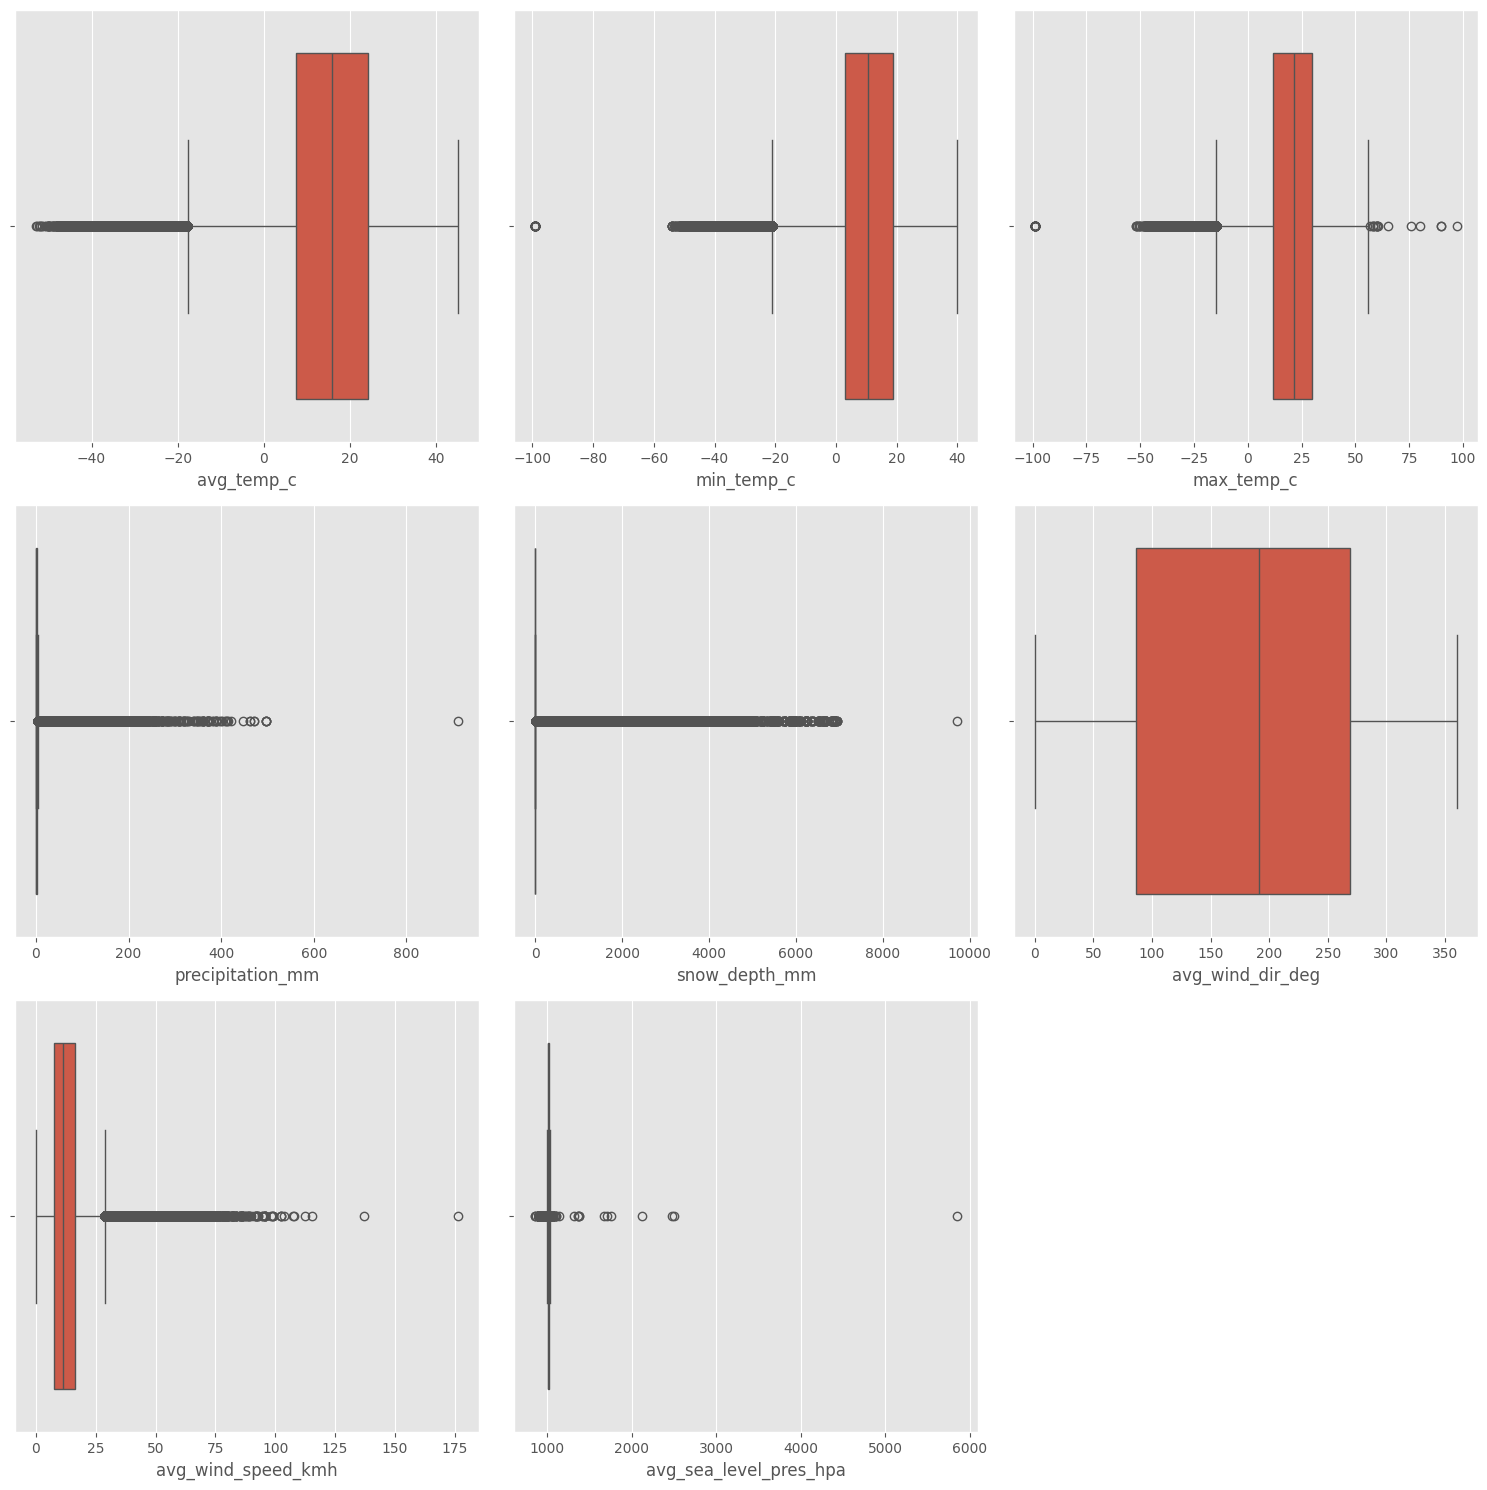

In [84]:
# Set up the matplotlib figure with 3 columns and as many rows as needed
# Since we have 7 plots, we'll need 3 rows (the last subplot will be empty)
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15)) # Adjust the figsize as needed

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Create each boxplot on a separate subplot
sns.boxplot(x=weather_city_country['avg_temp_c'], ax=axes[0])
sns.boxplot(x=weather_city_country['min_temp_c'], ax=axes[1])
sns.boxplot(x=weather_city_country['max_temp_c'], ax=axes[2])
sns.boxplot(x=weather_city_country['precipitation_mm'], ax=axes[3])
sns.boxplot(x=weather_city_country['snow_depth_mm'], ax=axes[4])
sns.boxplot(x=weather_city_country['avg_wind_dir_deg'], ax=axes[5])
sns.boxplot(x=weather_city_country['avg_wind_speed_kmh'], ax=axes[6])
sns.boxplot(x=weather_city_country['avg_sea_level_pres_hpa'], ax=axes[7])

# Hide the last two subplots (as they are not needed)
for i in [8]:
    fig.delaxes(axes[i])

# Adjust the layout
plt.tight_layout()
plt.show()

After reviewing the outliers for the `avg_sea_level_pres_hpa` column, it was determined there are a small number of outliers that are likely due to data entry errors. Therefore, we will cap the outliers at 850 hPA to 1200 hPa.

In [85]:
# Determine outliers for the `avg_sea_level_pres_hpa` column
weather_city_country['avg_sea_level_pres_hpa'].describe()

count   4179075.00
mean       1015.00
std           8.48
min         861.00
25%        1010.30
50%        1014.60
75%        1019.70
max        5852.70
Name: avg_sea_level_pres_hpa, dtype: float64

In [86]:
# Determine number of outliers for the `avg_sea_level_pres_hpa` column
weather_city_country[weather_city_country['avg_sea_level_pres_hpa'] > 1200].shape[0]

12

In [87]:
# Determine number of outliers for the `avg_sea_level_pres_hpa` column
weather_city_country[weather_city_country['avg_sea_level_pres_hpa'] < 850].shape[0]

0

In [88]:
# Review the data where the `avg_sea_level_pres_hpa` is greater than 1200 and less than 900
weather_city_country[(weather_city_country['avg_sea_level_pres_hpa'] > 1200) | (weather_city_country['avg_sea_level_pres_hpa'] < 850)]

,station_id,city,date,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,avg_wind_speed_kmh,avg_sea_level_pres_hpa,country,state,iso3,latitude,longitude,population,area,region,continent
149728,87344,Córdoba,2016-12-25,26.10,18.80,34.00,2.00,NaN,168.00,14.10,2122.70,Argentina,Non-US,ARG,-31.40,-64.18,42669500.00,2780400.00,South America,South America
150089,87344,Córdoba,2018-06-10,13.10,4.00,20.60,NaN,NaN,193.00,14.50,1379.00,Argentina,Non-US,ARG,-31.40,-64.18,42669500.00,2780400.00,South America,South America
158121,87715,Neuquén,2017-10-04,17.00,10.20,21.10,NaN,NaN,298.00,34.10,5852.70,Argentina,Non-US,ARG,-38.95,-68.06,42669500.00,2780400.00,South America,South America
182065,87938,Ushuaia,2017-01-09,7.90,5.50,12.90,0.50,NaN,238.00,29.90,1323.30,Argentina,Non-US,ARG,-54.79,-68.31,42669500.00,2780400.00,South America,South America
182085,87938,Ushuaia,2017-06-09,3.10,1.00,6.40,0.30,NaN,245.00,35.60,1712.40,Argentina,Non-US,ARG,-54.79,-68.31,42669500.00,2780400.00,South America,South America
182158,87938,Ushuaia,2018-01-27,11.30,8.60,17.00,0.50,NaN,NaN,13.10,1363.00,Argentina,Non-US,ARG,-54.79,-68.31,42669500.00,2780400.00,South America,South America
182179,87938,Ushuaia,2018-04-07,2.30,0.00,5.00,0.00,NaN,NaN,23.90,1375.30,Argentina,Non-US,ARG,-54.79,-68.31,42669500.00,2780400.00,South America,South America
182185,87938,Ushuaia,2018-07-21,2.20,0.80,5.70,NaN,NaN,324.00,5.90,2497.60,Argentina,Non-US,ARG,-54.79,-68.31,42669500.00,2780400.00,South America,South America
182186,87938,Ushuaia,2018-07-22,1.60,0.00,5.00,NaN,NaN,326.00,12.70,1667.90,Argentina,Non-US,ARG,-54.79,-68.31,42669500.00,2780400.00,South America,South America
182188,87938,Ushuaia,2018-07-24,6.40,3.00,10.00,0.30,NaN,294.00,25.90,2482.70,Argentina,Non-US,ARG,-54.79,-68.31,42669500.00,2780400.00,South America,South America


In [89]:
# Drop rows where the `avg_sea_level_pres_hpa` is > '1200' and < '850'
weather_city_country.drop(weather_city_country[(weather_city_country['avg_sea_level_pres_hpa'] > 1200) | \
    (weather_city_country['avg_sea_level_pres_hpa'] < 850)].index, inplace=True)

weather_city_country['avg_sea_level_pres_hpa'].describe()

count   4179063.00
mean       1014.99
std           8.04
min         861.00
25%        1010.30
50%        1014.60
75%        1019.70
max        1136.90
Name: avg_sea_level_pres_hpa, dtype: float64

<Axes: xlabel='avg_sea_level_pres_hpa'>

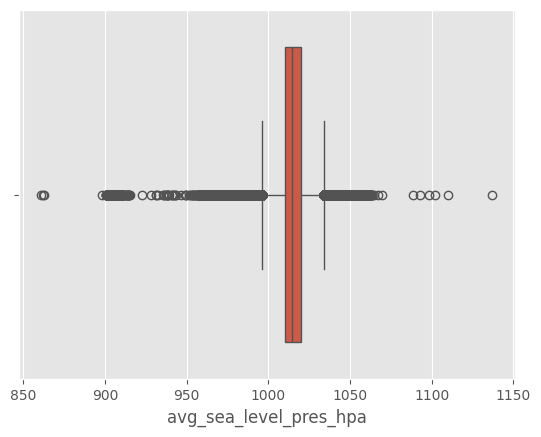

In [90]:
# Review outliers in boxplot for the `avg_sea_level_pres_hpa` column
sns.boxplot(x=weather_city_country['avg_sea_level_pres_hpa'])

#### 2.4.4.10 Secondary Review for Missing and Zero Values

Conduct a second review for missing values.
Decide on an imputation strategy for each column with missing values.

In [91]:
weather_city_country.isnull().sum()

station_id                      0
city                            0
date                            0
avg_temp_c                   1084
min_temp_c                   7747
max_temp_c                   7745
precipitation_mm           603860
snow_depth_mm             2628005
avg_wind_dir_deg          1140694
avg_wind_speed_kmh         196299
avg_sea_level_pres_hpa          0
country                         0
state                           0
iso3                            0
latitude                        0
longitude                       0
population                      0
area                            0
region                          0
continent                       0
dtype: int64

In [92]:
weather_city_country.shape, migraine_data.shape

((4179063, 20), (1377000, 10))

<Axes: >

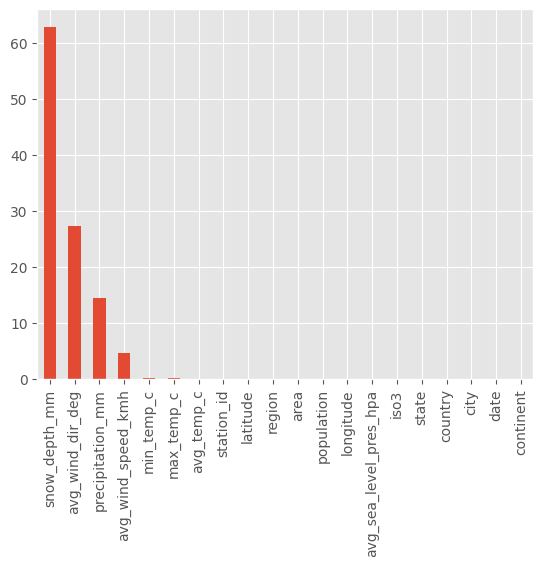

In [93]:
# Determine the percentage of missing values for each column
missing_percentages = weather_city_country.isnull().sum() / weather_city_country.shape[0] * 100

# Check for patterns in the missing values
missing_percentages.sort_values(ascending=False).plot(kind='bar')

<Axes: >

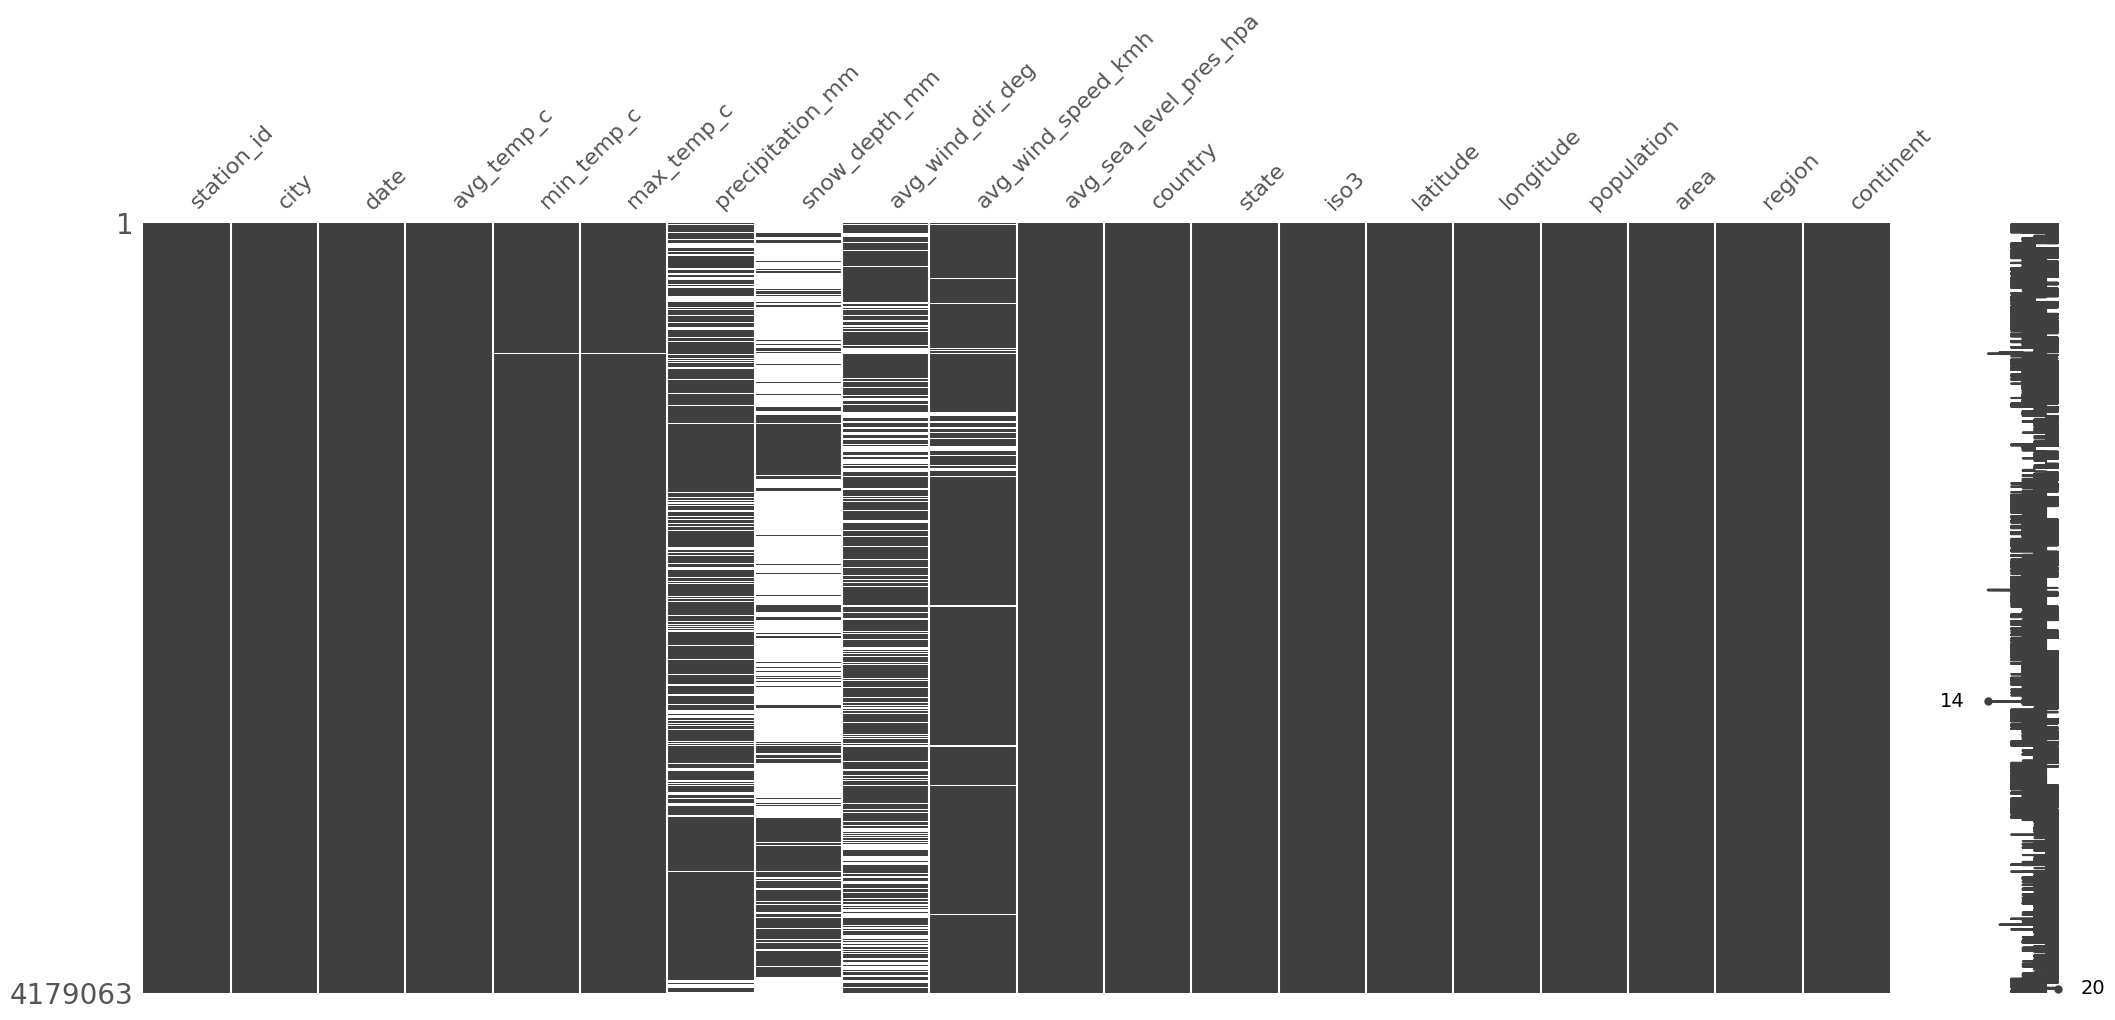

In [94]:
# Visualizing the missing values
msno.matrix(weather_city_country)

##### Handling Missing Values in `weather_city_country` DataFrame

The missingno matrix provides a visual representation of the missing values across different columns in the dataset and there does not seem to be any pattern in the missing values. The precipitation_mm column also has missing values, but these can logically be filled with zeroes, assuming that no record indicates no precipitation. The missing values for the snow_depth_mm column will be filled in using a forward fill method as snow depth is likely to remain constant from one day to the next. For the temperature columns (min_temp_c and max_temp_c), a K-nearest neighbors (KNN) imputation method is considered suitable to fill in the missing values, leveraging the spatial and temporal correlations in the data. After filling in the missing values in min_temp_c and max_temp_c, the avg_temp_c missing values will be imputed by utilizing linear interpolation method.

** Temperature Columns (min_temp_c, max_temp_c, avg_temp_c) **
- **Missing Values**: `min_temp_c` has 7,747 (0.2%) missing values, `max_temp_c` has 7,745 (0.2%), and `avg_temp_c` has 1,084 (0.1%).
- **Data Size**: The DataFrame has 4,179,075 entries.
- **Data Variability**: Given the temporal and geographical variability in temperatures, traditional imputation methods like mean or median could be misleading.
- **Options**:
    - *K-Nearest Neighbors (KNN)*: Used for `min_temp_c` and `max_temp_c` as the data is time-ordered and missing values are not clustered.
    - *Linear Interpolation*: `avg_temp_c` was imputed using linear interpolation after filling in the missing values in `min_temp_c` and `max_temp_c`.

** Precipitation and Snow Depth Columns (precipitation_mm, snow_depth_mm) **
- **Missing Values**: `precipitation_mm` has 603,864 (14.4%) missing values and `snow_depth_mm` has 2,628,017 (62.9%).
- **Data Size**: The DataFrame has 4,179,075 entries.
- **Data Variability**: Like temperature, these variables can also vary greatly.
- **Options**:
    - *Zero Filling*: Chosen as the most logical option for `precipitation_mm`, assuming that no recorded value implies no precipitation or snow.
    - *Forward Fill*: Utilizing the forward fill method to fill in missing values for the `snow_depth_mm` column, as snow depth is likely to remain constant from one day to the next.

** Wind Direction Column (avg_wind_dir_deg) **
- **Missing Values**: 1,140,696 (27.3%) missing values.
- **Data Size**: The DataFrame has 4,179,075 entries.
- **Data Variability**: Wind direction is cyclic (0 and 360 degrees are equivalent).
- **Options**:
    - *Mean Imputation*: Applied after converting the wind direction to radians, calculating the mean, and then converting back to degrees.

** Wind Speed Column (avg_wind_speed_kmh) **
- **Missing Values**: `avg_wind_speed_kmh` has 196,299 (4.7%) missing values.
- **Data Size**: The DataFrame has 4,179,075 entries.
- **Data Variability**: These variables also vary significantly.
- **Options**:
    - *IterativeImputer*: Used for the `avg_wind_speed_kmh` column.

After handling these missing values, additional data validation was conducted to ensure that the imputed values fall within expected ranges.

#### 2.4.4.11 Replacing Missing Values

Use techniques like mean imputation, median imputation, or more sophisticated methods like k-nearest neighbors or multiple imputations.

In [95]:
weather_city_country.isnull().sum()

station_id                      0
city                            0
date                            0
avg_temp_c                   1084
min_temp_c                   7747
max_temp_c                   7745
precipitation_mm           603860
snow_depth_mm             2628005
avg_wind_dir_deg          1140694
avg_wind_speed_kmh         196299
avg_sea_level_pres_hpa          0
country                         0
state                           0
iso3                            0
latitude                        0
longitude                       0
population                      0
area                            0
region                          0
continent                       0
dtype: int64

In [96]:
# Fill the missing values in the `precipitation_mm` column with 0
weather_city_country['precipitation_mm'].fillna(0, inplace=True)

# Fill the missing values in the `snow_depth_mm` column with forward fill
weather_city_country['snow_depth_mm'].ffill(inplace=True)

# Confirm the changes
weather_city_country.isnull().sum()

station_id                      0
city                            0
date                            0
avg_temp_c                   1084
min_temp_c                   7747
max_temp_c                   7745
precipitation_mm                0
snow_depth_mm                 755
avg_wind_dir_deg          1140694
avg_wind_speed_kmh         196299
avg_sea_level_pres_hpa          0
country                         0
state                           0
iso3                            0
latitude                        0
longitude                       0
population                      0
area                            0
region                          0
continent                       0
dtype: int64

In [97]:
# Fill the missing values in the `snow_depth_mm` column with 0
weather_city_country['snow_depth_mm'].fillna(0, inplace=True)

# Confirm the changes
weather_city_country.isnull().sum()

station_id                      0
city                            0
date                            0
avg_temp_c                   1084
min_temp_c                   7747
max_temp_c                   7745
precipitation_mm                0
snow_depth_mm                   0
avg_wind_dir_deg          1140694
avg_wind_speed_kmh         196299
avg_sea_level_pres_hpa          0
country                         0
state                           0
iso3                            0
latitude                        0
longitude                       0
population                      0
area                            0
region                          0
continent                       0
dtype: int64

NOTE: This code takes approximately 18 to 20 minutes to run. Therefore, it has been commented out.

In [98]:
# # Create a copy of the dataframe
# weather_city_country = weather_city_country.copy()

# # First, sort by weather_station and date
# weather_city_country.sort_values(by=['station_id', 'date'], inplace=True)

# # Create a subset DataFrame
# subset_df = weather_city_country[['min_temp_c', 'max_temp_c']]

# # Create the KNN imputer instance with 7 neighbors
# imputer = KNNImputer(n_neighbors=7)

# # Fit and transform the data
# subset_df_imputed = imputer.fit_transform(subset_df)

# # Replace the original columns with the imputed data
# weather_city_country[['min_temp_c', 'max_temp_c']] = subset_df_imputed

In [99]:
weather_city_country.isnull().sum()

station_id                      0
city                            0
date                            0
avg_temp_c                   1084
min_temp_c                      0
max_temp_c                      0
precipitation_mm                0
snow_depth_mm                   0
avg_wind_dir_deg          1140694
avg_wind_speed_kmh         196299
avg_sea_level_pres_hpa          0
country                         0
state                           0
iso3                            0
latitude                        0
longitude                       0
population                      0
area                            0
region                          0
continent                       0
dtype: int64

For the `avg_temp_c` missing values, we will utilize linear interpoloation to fill in the missing average temperature values. A new, temporary column will be created called `avg_temp_c_linear` to hold these values.

In [100]:
# Create a copy of the dataframe
weather_city_country = weather_city_country.copy()

# First, sort by weather_station and date
weather_city_country.sort_values(by=['station_id', 'date'], inplace=True)

# Then, apply linear interpolation within each group of station_id
weather_city_country['avg_temp_c_linear'] = weather_city_country.groupby('station_id')['avg_temp_c'].transform\
    (lambda x: x.interpolate(method='linear'))

Utilize the mean absolute error (MAE) to determine the accuracy of the interpolated values.

In [101]:
# Filter out rows where either of the two columns is NaN
filtered_df_linInt = weather_city_country.dropna(subset=['avg_temp_c', 'avg_temp_c_linear'])

# Calculate mean absolute error
mae = mean_absolute_error(filtered_df_linInt['avg_temp_c'], filtered_df_linInt['avg_temp_c_linear'])

# Print the mean absolute error
print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 0.0


As noted above, the MAE is 0.0, so we will use the interpolated values to fill in the missing values for the `avg_temp_c` column. We will then drop the `avg_temp_c_linear` column.

In [102]:
weather_city_country.isnull().sum()

# Review the data where the `avg_temp_c_linear` is missing
weather_city_country[weather_city_country['avg_temp_c_linear'].isnull()]

# Drop the `avg_temp_c_linear` missing value with index 3661614
weather_city_country.drop(index=3661614, inplace=True)

In [103]:
# Confirm the changes
weather_city_country.isnull().sum()

station_id                      0
city                            0
date                            0
avg_temp_c                   1083
min_temp_c                      0
max_temp_c                      0
precipitation_mm                0
snow_depth_mm                   0
avg_wind_dir_deg          1140693
avg_wind_speed_kmh         196298
avg_sea_level_pres_hpa          0
country                         0
state                           0
iso3                            0
latitude                        0
longitude                       0
population                      0
area                            0
region                          0
continent                       0
avg_temp_c_linear               0
dtype: int64

Replace the missing values in the `avg_temp_c` column with the values from the `avg_temp_c_linear` column.

In [104]:
# Fill missing values in the 'avg_temp_c' column with the linear interpolated values 
weather_city_country['avg_temp_c'] = weather_city_country['avg_temp_c_linear']

Drop the `avg_temp_c_linear` column and check for any remaining missing values.

In [105]:
# Drop the 'avg_temp_c_linear' column
weather_city_country.drop(columns=['avg_temp_c_linear'], inplace=True)

# Check for missing values
weather_city_country.isnull().sum()

station_id                      0
city                            0
date                            0
avg_temp_c                      0
min_temp_c                      0
max_temp_c                      0
precipitation_mm                0
snow_depth_mm                   0
avg_wind_dir_deg          1140693
avg_wind_speed_kmh         196298
avg_sea_level_pres_hpa          0
country                         0
state                           0
iso3                            0
latitude                        0
longitude                       0
population                      0
area                            0
region                          0
continent                       0
dtype: int64

** Handling Missing Values for Average Wind Direction **

Imputing missing values with the mean direction helps to maintain the distribution of the wind direction data. It is assumed that the missing values are randomly distributed and that the mean is a reasonable estimate of the central tendency for the wind direction.

Wind direction is a circular (or angular) variable, meaning that the values represent points on a circle (0 and 360 degrees are the same). So, it's important to calculate the mean direction using trigonometric functions (sin and cos) rather than simply averaging the degree values, which could result in an incorrect mean direction if the values fall around the point where the scale wraps around.

In [106]:
# Convert degrees to radians
radians = np.radians(weather_city_country['avg_wind_dir_deg'].dropna())

# Calculate the mean direction
mean_angle = np.arctan2(np.mean(np.sin(radians)), np.mean(np.cos(radians)))

# Convert back to degrees
mean_angle = np.degrees(mean_angle) % 360

# Fill NaNs
weather_city_country['avg_wind_dir_deg'].fillna(mean_angle, inplace=True)

In [107]:
weather_city_country.isnull().sum()

station_id                     0
city                           0
date                           0
avg_temp_c                     0
min_temp_c                     0
max_temp_c                     0
precipitation_mm               0
snow_depth_mm                  0
avg_wind_dir_deg               0
avg_wind_speed_kmh        196298
avg_sea_level_pres_hpa         0
country                        0
state                          0
iso3                           0
latitude                       0
longitude                      0
population                     0
area                           0
region                         0
continent                      0
dtype: int64

Utilizing the `IterativeImputer` algorithm to fill in the missing values for the `avg_wind_speed_kmh` column. This algorithm is suitable for a large dataset as it will model each feature with missing values as a function of other features, and uses that estimate for imputation. The `IterativeImputer` algorithm is also suitable for a dataset with a mix of categorical and numerical features, as is the case with the `weather_city_country` DataFrame. 

In [108]:
# Create a subset DataFrame
subset_df_wind = weather_city_country[['avg_wind_speed_kmh']]

# Create the imputer instance
iterative_imputer = IterativeImputer()

# Fit and transform the data
subset_df_wind_imputed = iterative_imputer.fit_transform(subset_df_wind)

# Replace the original columns with the imputed data
weather_city_country['avg_wind_speed_kmh'] = subset_df_wind_imputed

In [109]:
weather_city_country.isnull().sum()

station_id                0
city                      0
date                      0
avg_temp_c                0
min_temp_c                0
max_temp_c                0
precipitation_mm          0
snow_depth_mm             0
avg_wind_dir_deg          0
avg_wind_speed_kmh        0
avg_sea_level_pres_hpa    0
country                   0
state                     0
iso3                      0
latitude                  0
longitude                 0
population                0
area                      0
region                    0
continent                 0
dtype: int64

#### 2.4.4.12 Data Transformation

Normalize or standardize numerical columns if needed.
Log transformation for skewed data.

Given that the migraine data is annual, we need to add a 'year' column to the weather data and filter it by year.

In [110]:
# Make a copy of the dataframe
weather_city_country = weather_city_country.copy()

# Create a new column for the year
weather_city_country['year'] = weather_city_country['date'].dt.year

weather_city_country

,station_id,city,date,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,avg_wind_speed_kmh,avg_sea_level_pres_hpa,country,state,iso3,latitude,longitude,population,area,region,continent,year
2816654,01008,Longyearbyen,1994-11-06,-17.30,-19.20,-11.60,0.00,300.00,146.00,12.70,1020.50,Svalbard and Jan Mayen,Non-US,SJM,78.22,15.55,2562.00,62049.00,Nordic Countries,Europe,1994
2816655,01008,Longyearbyen,1994-11-12,-12.20,-15.60,-10.50,0.00,250.00,141.00,15.50,1017.20,Svalbard and Jan Mayen,Non-US,SJM,78.22,15.55,2562.00,62049.00,Nordic Countries,Europe,1994
2816656,01008,Longyearbyen,1994-11-13,-12.60,-17.40,-8.30,2.00,300.00,286.66,5.90,1005.90,Svalbard and Jan Mayen,Non-US,SJM,78.22,15.55,2562.00,62049.00,Nordic Countries,Europe,1994
2816657,01008,Longyearbyen,1994-11-27,-6.80,-7.70,-5.10,3.00,400.00,286.66,9.60,975.00,Svalbard and Jan Mayen,Non-US,SJM,78.22,15.55,2562.00,62049.00,Nordic Countries,Europe,1994
2816658,01008,Longyearbyen,1994-12-04,-2.60,-5.00,1.40,5.00,500.00,286.66,25.10,989.00,Svalbard and Jan Mayen,Non-US,SJM,78.22,15.55,2562.00,62049.00,Nordic Countries,Europe,1994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2590522,KPHF0,Jamestown,2023-08-23,22.80,19.40,26.70,0.00,0.00,68.00,12.60,1019.10,Saint Helena,Non-US,SHN,37.21,-76.77,4255.00,390.00,Western Africa,Africa,2023
2590523,KPHF0,Jamestown,2023-08-24,23.70,17.20,28.90,0.00,0.00,168.00,10.90,1016.50,Saint Helena,Non-US,SHN,37.21,-76.77,4255.00,390.00,Western Africa,Africa,2023
2590524,KPHF0,Jamestown,2023-08-25,27.60,22.80,32.80,0.00,0.00,201.00,19.60,1012.50,Saint Helena,Non-US,SHN,37.21,-76.77,4255.00,390.00,Western Africa,Africa,2023
2590525,KPHF0,Jamestown,2023-08-26,27.30,23.90,31.20,0.00,0.00,327.00,12.80,1009.90,Saint Helena,Non-US,SHN,37.21,-76.77,4255.00,390.00,Western Africa,Africa,2023


In [111]:
# Sort weather_city_country by station_id and date
weather_city_country.sort_values\
    (by=['station_id', 'date'], inplace=True)

#### 2.4.4.13 Checking and Removing Duplicates

Use .duplicated() to check for duplicate rows and .drop_duplicates() to remove them.

In [112]:
# Check for duplicate rows
weather_city_country.duplicated().sum()

120512

In [113]:
weather_city_country.shape

(4179062, 21)

In [114]:
# Drop duplicate rows
weather_city_country.drop_duplicates(inplace=True)

In [115]:
# Check for duplicate rows
weather_city_country.duplicated().sum()

0

In [116]:
# Check the shape of the dataframe
weather_city_country.shape

(4058550, 21)

#### 2.4.4.14 Summary for Data Cleaning Steps for `weather_data`

In this section, we have executed a comprehensive set of data cleaning actions to enhance the quality and usability of the `weather_data` DataFrame. Here's a summary of what was achieved:

1. **Data Consistency Check**: Conducted an initial review for consistency across all columns to ensure no anomalies or contradictions exist.
  
2. **Initial Review for Missing and Zero Values**: Identified columns with missing or zero values and marked them for further action.
  
3. **Drop Unnecessary Columns/Rows**: Removed columns and rows that were not pertinent to the scope of our analysis, thereby simplifying the dataset.
  
4. **Rename Columns**: Renamed columns to align with a consistent naming convention, enhancing the DataFrame's readability.
  
5. **Standardizing Text Data**: Standardized the text data in fields like country names and states to ensure uniformity across datasets.
  
6. **Merging with Other Datasets**: Merged the `city_country` DataFrame with the `weather_data` bringing us `weather_city_country` DataFrame after ensuring key columns were standardized.
  
7. **Data Type Conversion**: Converted columns to their appropriate data types to facilitate subsequent analysis.
  
8. **Handling Categorical Variables**: Label-encoded or one-hot encoded categorical variables, preparing them for modeling.
  
9. **Outliers Detection and Treatment**: Detected outliers using boxplots and IQR methods and decided on a treatment strategy.
  
10. **Second Review for Missing Values**: Conducted a second review for missing values and selected an imputation strategy for each column with missing data.
  
11. **Replace Missing Values**: Applied various techniques to impute missing values, ranging from mean and median imputation to more advanced methods.
  
12. **Data Transformation**: Normalized or standardized numerical columns and applied log transformation to skewed data where necessary. Added a `year` column to the DataFrame to facilitate filtering by year.
  
13. **Checking and Removing Duplicates**: Checked for duplicate rows and removed them to ensure data integrity.

These cleaning steps have ensured that the `weather_data` and newly combined `weather_city_country` DataFrame are now in a state that is well-prepared for the subsequent stages of data integration, feature engineering, and modeling. The methodologies and strategies applied here will be similarly applied to the remaining DataFrames: `migraine_data`.

#### 2.4.4.15 Export the Cleaned `weather_city_country` Data

In [117]:
# Export the processed weather_city_country data

# to csv
weather_city_country.to_csv('../data/processed/weather_city_country_data.csv', index=False)

# to parquet
weather_city_country.to_parquet('../data/processed/weather_city_country_data.parquet', index=False)

### 2.4.5 DataFrame: `migraine_data`

#### 2.4.5.1 Data Consistency Check

- Check if the data is consistent across all columns, i.e., no anomalies or contradictions
- Use .describe() to obtain summary statistics, if appropriate
- Use .info() to get an overview of the dataset

##### 2.4.5.1.1 View Data

In [118]:
# View the migraine data
migraine_data

,measure,location,sex,age,cause,metric,year,val,upper,lower
0,Prevalence,Albania,Male,<5 years,Migraine,Number,1990,0.00,0.00,0.00
1,Prevalence,Albania,Female,<5 years,Migraine,Number,1990,0.00,0.00,0.00
2,Prevalence,Albania,Male,<5 years,Migraine,Percent,1990,0.00,0.00,0.00
3,Prevalence,Albania,Female,<5 years,Migraine,Percent,1990,0.00,0.00,0.00
4,Prevalence,Albania,Male,<5 years,Migraine,Rate,1990,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...
376995,Prevalence,Texas,Female,85+ years,Tension-type headache,Number,2019,74932.80,97941.43,55430.84
376996,Prevalence,Texas,Male,85+ years,Tension-type headache,Percent,2019,0.26,0.35,0.19
376997,Prevalence,Texas,Female,85+ years,Tension-type headache,Percent,2019,0.30,0.39,0.22
376998,Prevalence,Texas,Male,85+ years,Tension-type headache,Rate,2019,26262.17,34497.02,19078.50


##### 2.4.5.1.2 Summary Statistics

In [119]:
# Obtain summary statistics for the migraine data
migraine_data.describe()

,year,val,upper,lower
count,1377000.00,1377000.00,1377000.00,1377000.00
mean,2004.50,66682.19,89022.70,48215.43
std,8.66,500501.72,668978.21,362304.42
min,1990.00,0.00,0.00,0.00
25%,1997.00,0.27,0.38,0.19
50%,2004.50,7773.30,10322.51,5681.24
75%,2012.00,29892.72,41294.32,20976.21
max,2019.00,24066264.03,31933576.82,17424140.57


##### 2.4.5.1.3 Data Summary

** General Overview **

This dataset is a comprehensive time series spanning from 1990 to 2019, with 1,377,000 observations. It includes yearly data points and is mainly focused on the variable 'val', with 'upper' and 'lower' providing possible bounds that might indicate confidence intervals or errors.

** Columns Information **

- **year**: Ranges from 1990 to 2019, with each year having a substantial number of observations, matching the overall data count.
- **val**: The primary measurement variable. It has a mean of 66,682.19 and a high standard deviation, suggesting wide variability. The range is from 0 to over 24 million.
- **upper**: Potentially an upper bound estimate, with a higher average than 'val', and a large standard deviation, indicating a broad spread.
- **lower**: Likely a lower bound estimate, with a lower average than 'val', and again, a large standard deviation, pointing to a wide spread in the data.

** Key Takeaways **

- **Time Series Data**: The structure suggests trend analysis over the three-decade span could be insightful.
- **Large Spread**: High standard deviations across all variables point to significant variability, necessitating further investigation.
- **Potential Outliers**: The maximum values are much larger than the mean, implying the existence of outliers that may affect analyses.
- **Data Density**: The lack of missing values in the summary implies no immediate need for data imputation.

For analytical readiness, understanding the context of 'val' and the nature of the 'upper' and 'lower' bounds will be crucial. Data normalization and outlier detection will likely play key roles in preparing this dataset for any subsequent modeling or analysis.

##### 2.4.5.1.4 Column Overview

In [120]:
migraine_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1377000 entries, 0 to 376999
Data columns (total 10 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   measure   1377000 non-null  object 
 1   location  1377000 non-null  object 
 2   sex       1377000 non-null  object 
 3   age       1377000 non-null  object 
 4   cause     1377000 non-null  object 
 5   metric    1377000 non-null  object 
 6   year      1377000 non-null  int64  
 7   val       1377000 non-null  float64
 8   upper     1377000 non-null  float64
 9   lower     1377000 non-null  float64
dtypes: float64(3), int64(1), object(6)
memory usage: 115.6+ MB


##### 2.4.5.1.5 DataFrame Summary

###### General Information

This DataFrame is a structured dataset with 1,377,000 entries and a total of 10 columns. The index ranges from 0 to 376999, which may indicate a multi-index or concatenated DataFrame from multiple sources or groups.

###### Columns and Data Types

The DataFrame comprises a mix of numerical and categorical data types, detailed as follows:

- **measure, location, sex, age, cause, metric**: These six columns are of the `object` data type, usually indicating categorical or textual information.
- **year**: Contains yearly data as integers (`int64`), spanning an unspecified range within the entries.
- **val, upper, lower**: These columns are of the `float64` data type, holding numerical values which could represent measurements along with their upper and lower bounds.

###### Key Takeaways

- **Data Richness**: The DataFrame's substantial size points to a rich dataset that is likely to be suited for in-depth analysis.
- **Categorical and Numerical Balance**: There is a balance between categorical (`object`) and numerical (`int64`, `float64`) data types, which allows for a diverse range of analytical approaches including trend analysis, statistical testing, and potentially machine learning modeling.
- **Consistent Non-Null Data**: With all columns being non-null across over a million entries, data quality appears to be high, reducing the need for initial data cleaning steps related to handling missing values.
- **Memory Usage**: The dataset consumes approximately 115.6+ MB of memory, which is an important consideration for data processing and analysis pipeline, especially when working with in-memory computation frameworks.

In preparing this dataset for analysis, particular attention should be paid to the categorization of the `object` type columns to ensure they are properly encoded for any kind of analytical model. Additionally, understanding the relationships between `val`, `upper`, and `lower` columns in the context of `measure`, `location`, `sex`, `age`, `cause`, and `metric` will be critical for extracting meaningful insights.

#### 2.4.5.2 Initial Review for Missing and Zero Values

Conduct an initial review for missing values using .isna().sum() and for zero values.

In [121]:
# Check for missing values
print("\nMigraine Missing Values:\n")
print(migraine_data.isnull().sum())

# Check for zero values
print("\nMigraine Zero Counts:\n")
zero_counts = (migraine_data == 0).sum()
print(zero_counts)


Migraine Missing Values:

measure     0
location    0
sex         0
age         0
cause       0
metric      0
year        0
val         0
upper       0
lower       0
dtype: int64

Migraine Zero Counts:

measure         0
location        0
sex             0
age             0
cause           0
metric          0
year            0
val         91800
upper       91800
lower       91800
dtype: int64


No missing values in this dataset.

We need to address the zero values in the `val`, `upper`, and `lower` columns. We will investigate the distribution of these values to determine the best method for handling them.

In [122]:
# Print rows with zero values
zero_rows_any = migraine_data[(migraine_data == 0).any(axis=1)]
print(zero_rows_any)

           measure    location     sex       age                  cause  \
0       Prevalence     Albania    Male  <5 years               Migraine   
1       Prevalence     Albania  Female  <5 years               Migraine   
2       Prevalence     Albania    Male  <5 years               Migraine   
3       Prevalence     Albania  Female  <5 years               Migraine   
4       Prevalence     Albania    Male  <5 years               Migraine   
...            ...         ...     ...       ...                    ...   
371238  Prevalence  New Jersey  Female  <5 years  Tension-type headache   
371239  Prevalence  New Jersey    Male  <5 years  Tension-type headache   
371240  Prevalence  New Jersey  Female  <5 years  Tension-type headache   
371241  Prevalence  New Jersey    Male  <5 years  Tension-type headache   
371242  Prevalence  New Jersey  Female  <5 years  Tension-type headache   

         metric  year  val  upper  lower  
0        Number  1990 0.00   0.00   0.00  
1        Numb

In [123]:
# Calculate number of rows with zero `val` for `<5 years`
zero_rows_less_than_5 = migraine_data[(migraine_data['val'] == 0) & (migraine_data['age'] == '<5 years')]

# Print number of rows with zero `val` for `<5 years`
print(f"Number of rows with zero `val` for `<5 years`: {zero_rows_less_than_5.shape[0]}")

Number of rows with zero `val` for `<5 years`: 91800


In [124]:
# Check the counts of the population's age groups
migraine_data['age'].value_counts()

age
<5 years       91800
15-19 years    91800
20-24 years    91800
25-29 years    91800
30-34 years    91800
35-39 years    91800
40-44 years    91800
45-49 years    91800
50-54 years    91800
55-59 years    91800
60-64 years    91800
5-14 years     91800
85+ years      91800
65-74 years    91800
75-84 years    91800
Name: count, dtype: int64

The number of zero values in the `val`, `upper`, and `lower` columns is 91,800. After further investigation, there are also 91,800 rows where the age of the population is <5 years old. Since this is perfectly reasonable explanation, we will remove these rows from the dataset and this analysis.

#### 2.4.5.3 Drop Unnecessary Columns/Rows

Drop columns or rows that are not needed for the analysis based on the project's scope.

*Keeping* all columns:
- 'measure'
- 'location'
- 'sex'
- 'age'
- 'cause'
- 'metric'
- 'year'
- 'val'
- 'upper'
- 'lower'

In [125]:
# Drop rows that meet the condition
migraine_data.drop(
    migraine_data.query("`age` == '<5 years' and `val` == 0").index, 
    inplace=True
)

# Confirm the changes
migraine_data['age'].value_counts()

age
40-44 years    83306
45-49 years    82509
30-34 years    81684
60-64 years    80972
20-24 years    80835
85+ years      80776
75-84 years    80693
55-59 years    80692
50-54 years    80661
35-39 years    80626
25-29 years    80587
15-19 years    80459
5-14 years     80105
65-74 years    79552
Name: count, dtype: int64

In [126]:
# Print rows with zero values
zero_rows_any = migraine_data[(migraine_data == 0).any(axis=1)]
print(zero_rows_any)

Empty DataFrame
Columns: [measure, location, sex, age, cause, metric, year, val, upper, lower]
Index: []


In [127]:
migraine_data['measure'].unique()

array(['Prevalence'], dtype=object)

For this analysis, we will only be looking at the prevalence (total # of cases in the population) of headache disorders (i.e., migraine, tension-type headache) and confirmed no other measure name columns are present in our dataset. We will remove all percent and rate values, as we are only interested in the total number of cases.

In [128]:
migraine_data['metric'].unique()

array(['Number', 'Percent', 'Rate'], dtype=object)

In [129]:
# Copy the migraine_data dataframe
migraine_data = migraine_data.copy()

# Identify indices to drop for 'metric' column
metric_indices_to_drop = migraine_data[migraine_data['metric'].isin(['Percent', 'Rate'])].index

# Drop rows
migraine_data = migraine_data.drop(metric_indices_to_drop)

# Confirm the changes
migraine_data['metric'].unique()

array(['Number'], dtype=object)

In [130]:
migraine_data.head()

,measure,location,sex,age,cause,metric,year,val,upper,lower
3415,Prevalence,Taiwan (Province of China),Male,85+ years,Migraine,Number,2011,5249.38,6903.76,3990.16
3421,Prevalence,Taiwan (Province of China),Male,85+ years,Migraine,Number,2012,5618.06,7341.49,4266.90
3427,Prevalence,Taiwan (Province of China),Male,85+ years,Migraine,Number,2013,5999.05,7848.98,4565.28
3433,Prevalence,Taiwan (Province of China),Male,85+ years,Migraine,Number,2014,6424.09,8403.95,4870.36
3439,Prevalence,Taiwan (Province of China),Male,85+ years,Migraine,Number,2015,6721.02,8764.60,5091.28


The measure and metric columns will be dropped as they are no longer needed. The val, upper, and lower columns will be renamed to total_cases, total_cases_upper_ci, and total_cases_lower_ci, respectively.

In [131]:
# Drop the `measure` and `metric` columns
migraine_data.drop(columns=['measure', 'metric'], inplace=True)

# Confirm the changes
migraine_data.head()

,location,sex,age,cause,year,val,upper,lower
3415,Taiwan (Province of China),Male,85+ years,Migraine,2011,5249.38,6903.76,3990.16
3421,Taiwan (Province of China),Male,85+ years,Migraine,2012,5618.06,7341.49,4266.90
3427,Taiwan (Province of China),Male,85+ years,Migraine,2013,5999.05,7848.98,4565.28
3433,Taiwan (Province of China),Male,85+ years,Migraine,2014,6424.09,8403.95,4870.36
3439,Taiwan (Province of China),Male,85+ years,Migraine,2015,6721.02,8764.60,5091.28


#### 2.4.5.4 Rename Columns

Rename columns to have meaningful names and to follow a consistent naming convention.

In [132]:
# Rename the `val` column to `total_cases`
migraine_data.rename(columns={'val': 'total_cases'}, inplace=True)

# Rename the `upper` column to `total_cases_upper_ci`
migraine_data.rename(columns={'upper': 'total_cases_upper_ci'}, inplace=True)

# Rename the `lower` column to `total_cases_lower_ci`
migraine_data.rename(columns={'lower': 'total_cases_lower_ci'}, inplace=True)

# Confirm the changes
migraine_data.head()

,location,sex,age,cause,year,total_cases,total_cases_upper_ci,total_cases_lower_ci
3415,Taiwan (Province of China),Male,85+ years,Migraine,2011,5249.38,6903.76,3990.16
3421,Taiwan (Province of China),Male,85+ years,Migraine,2012,5618.06,7341.49,4266.90
3427,Taiwan (Province of China),Male,85+ years,Migraine,2013,5999.05,7848.98,4565.28
3433,Taiwan (Province of China),Male,85+ years,Migraine,2014,6424.09,8403.95,4870.36
3439,Taiwan (Province of China),Male,85+ years,Migraine,2015,6721.02,8764.60,5091.28


In [133]:
# Check shape of migraine_data
print("\nMigraine Data Shape: " + str(migraine_data.shape))

# Check for missing values
print("\nMigraine Missing Values:")
print(migraine_data.isnull().sum())


Migraine Data Shape: (61444, 8)

Migraine Missing Values:
location                0
sex                     0
age                     0
cause                   0
year                    0
total_cases             0
total_cases_upper_ci    0
total_cases_lower_ci    0
dtype: int64


#### 2.4.5.5 Standardizing Text Data

Standardize country names, state names, and other text-based fields to ensure uniformity.
Use .str.lower() or .str.upper() to standardize text.

##### 2.4.5.5.1 Standardize `country` Names

Before we can merge the migraine data with the weather data, we need to split the standardized `location` column into `country` and `state` columns. We have already confirmed that the `city_country` dataframe contains both a country and state column so we will use this dataframe to populate the `country` and `state` columns in the migraine data. We will then drop the `location` column from the migraine data. Finally, we will merge the migraine data with the weather data on the `country`, `state`, and `year` columns.

In [134]:
migraine_data.head(1)

,location,sex,age,cause,year,total_cases,total_cases_upper_ci,total_cases_lower_ci
3415,Taiwan (Province of China),Male,85+ years,Migraine,2011,5249.38,6903.76,3990.16


In [135]:
migraine_data['location'].unique()

array(['Taiwan (Province of China)', 'Marshall Islands', 'Viet Nam',
       'Philippines', 'Samoa', 'Albania', 'Timor-Leste', 'Tajikistan',
       'Myanmar', 'Georgia', "Democratic People's Republic of Korea",
       "Lao People's Democratic Republic", 'Azerbaijan', 'Thailand',
       'Mongolia', 'China', 'Fiji', 'Maldives', 'Papua New Guinea',
       'Vanuatu', 'Uzbekistan', 'Micronesia (Federated States of)',
       'Malaysia', 'Armenia', 'Cambodia', 'Tonga', 'Turkmenistan',
       'Montenegro', 'Sri Lanka', 'Solomon Islands', 'Slovakia',
       'Croatia', 'Bulgaria', 'Australia', 'Brunei Darussalam',
       'North Macedonia', 'Greece', 'Hungary', 'Denmark', 'Serbia',
       'Lithuania', 'Andorra', 'Republic of Moldova',
       'Bosnia and Herzegovina', 'Germany', 'Singapore', 'Romania',
       'Cyprus', 'Poland', 'Czechia', 'Latvia', 'Norway', 'Israel',
       'Switzerland', 'Ukraine', 'Belgium', 'Republic of Korea', 'France',
       'Ireland', 'Barbados', 'Chile', 'Sweden', 'Japan'

In [136]:
migraine_data_countries_and_states = migraine_data['location'].unique()

migraine_data_countries_and_states

array(['Taiwan (Province of China)', 'Marshall Islands', 'Viet Nam',
       'Philippines', 'Samoa', 'Albania', 'Timor-Leste', 'Tajikistan',
       'Myanmar', 'Georgia', "Democratic People's Republic of Korea",
       "Lao People's Democratic Republic", 'Azerbaijan', 'Thailand',
       'Mongolia', 'China', 'Fiji', 'Maldives', 'Papua New Guinea',
       'Vanuatu', 'Uzbekistan', 'Micronesia (Federated States of)',
       'Malaysia', 'Armenia', 'Cambodia', 'Tonga', 'Turkmenistan',
       'Montenegro', 'Sri Lanka', 'Solomon Islands', 'Slovakia',
       'Croatia', 'Bulgaria', 'Australia', 'Brunei Darussalam',
       'North Macedonia', 'Greece', 'Hungary', 'Denmark', 'Serbia',
       'Lithuania', 'Andorra', 'Republic of Moldova',
       'Bosnia and Herzegovina', 'Germany', 'Singapore', 'Romania',
       'Cyprus', 'Poland', 'Czechia', 'Latvia', 'Norway', 'Israel',
       'Switzerland', 'Ukraine', 'Belgium', 'Republic of Korea', 'France',
       'Ireland', 'Barbados', 'Chile', 'Sweden', 'Japan'

In [137]:
migraine_data_location_replacement_dict = {
    'Taiwan (Province of China)': 'Taiwan',
    'Viet Nam': 'Vietnam',
    "Democratic People's Republic of Korea": 'North Korea',
    "Lao People's Democratic Republic": 'Laos',
    'Democratic Republic of the Congo': 'Congo (Kinshasa)',
    'Micronesia (Federated States of)': 'Micronesia',
    'North Macedonia': 'Macedonia',
    'Brunei Darussalam': 'Brunei',
    'Republic of Korea': 'South Korea',
    'Bolivia (Plurinational State of)': 'Bolivia',
    'Venezuela (Bolivarian Republic of)': 'Venezuela',
    'Iran (Islamic Republic of)': 'Iran',
    'United Republic of Tanzania': 'Tanzania',    
    'Republic of the Congo': 'Congo (Brazzaville)',
    'Republic of Moldova': 'Moldova',
    'Korea, North': 'North Korea',
    'Korea, South': 'South Korea',
    'São Tomé and Príncipe': 'Sao Tome and Principe', 
    'The Bahamas': 'Bahamas',
    'The Gambia': 'Gambia',
    'United States': 'United States of America'
}

# Replace the country names in the migraine_data dataframe
migraine_data['location'].replace(migraine_data_location_replacement_dict, inplace=True)

migraine_data['location'].unique()

array(['Taiwan', 'Marshall Islands', 'Vietnam', 'Philippines', 'Samoa',
       'Albania', 'Timor-Leste', 'Tajikistan', 'Myanmar', 'Georgia',
       'North Korea', 'Laos', 'Azerbaijan', 'Thailand', 'Mongolia',
       'China', 'Fiji', 'Maldives', 'Papua New Guinea', 'Vanuatu',
       'Uzbekistan', 'Micronesia', 'Malaysia', 'Armenia', 'Cambodia',
       'Tonga', 'Turkmenistan', 'Montenegro', 'Sri Lanka',
       'Solomon Islands', 'Slovakia', 'Croatia', 'Bulgaria', 'Australia',
       'Brunei', 'Macedonia', 'Greece', 'Hungary', 'Denmark', 'Serbia',
       'Lithuania', 'Andorra', 'Moldova', 'Bosnia and Herzegovina',
       'Germany', 'Singapore', 'Romania', 'Cyprus', 'Poland', 'Czechia',
       'Latvia', 'Norway', 'Israel', 'Switzerland', 'Ukraine', 'Belgium',
       'South Korea', 'France', 'Ireland', 'Barbados', 'Chile', 'Sweden',
       'Japan', 'Finland', 'Iceland', 'Netherlands', 'Dominica',
       'United States of America', 'Haiti', 'Bahamas', 'Malta',
       'Luxembourg', 'Argentina

In [138]:
# Convert original list to sets
migraine_data_countries_and_states = migraine_data["location"].unique()

set_migraine_countries_and_states = set(migraine_data_countries_and_states)
set_US_states = set(US_STATES)
set_countries = set(COUNTRIES)

# Create a new list excluding the U.S. states
migraine_filtered_countries_list = [
    item for item in set_migraine_countries_and_states if item not in set_US_states
]

# View the list
migraine_filtered_countries_list

['Lebanon',
 'Albania',
 'Bosnia and Herzegovina',
 'Australia',
 'Sudan',
 'Turkmenistan',
 'Colombia',
 'Mongolia',
 'Ukraine',
 'Czechia',
 'Finland',
 'Kuwait',
 'Nigeria',
 'Germany',
 'Greenland',
 'Nepal',
 'Mali',
 'Bahrain',
 'Suriname',
 'Congo (Kinshasa)',
 'Lesotho',
 'Bermuda',
 'Benin',
 'Ghana',
 'Central African Republic',
 'Sri Lanka',
 'Israel',
 'Saint Lucia',
 'Djibouti',
 'Samoa',
 'Cambodia',
 'Chad',
 'Iceland',
 'Kenya',
 'Burundi',
 'Egypt',
 'Dominica',
 'Greece',
 'Andorra',
 'South Africa',
 'Algeria',
 'Bhutan',
 'Croatia',
 'China',
 'Qatar',
 'Slovakia',
 'Myanmar',
 'Saudi Arabia',
 'Sao Tome and Principe',
 'Portugal',
 'Guinea',
 'Nauru',
 'Taiwan',
 'South Korea',
 'Madagascar',
 'Eritrea',
 'Rwanda',
 'Belize',
 'Equatorial Guinea',
 'Monaco',
 'San Marino',
 'Comoros',
 'American Samoa',
 'Grenada',
 'Vietnam',
 'Philippines',
 'Trinidad and Tobago',
 'Ecuador',
 'Yemen',
 'Lithuania',
 'Oman',
 'Morocco',
 'Barbados',
 'Uganda',
 'Cook Islands',
 '

In [139]:
# Copy the migraine_data dataframe
migraine_data = migraine_data.copy()

# Create a new column for the country using the `location` column and the `COUNTRIES` list
migraine_data['country'] = migraine_data['location'].apply\
    (lambda x: x if x in migraine_filtered_countries_list else 'United States of America')

# Confirm the changes
migraine_data['country'].unique()

array(['Taiwan', 'Marshall Islands', 'Vietnam', 'Philippines', 'Samoa',
       'Albania', 'Timor-Leste', 'Tajikistan', 'Myanmar',
       'United States of America', 'North Korea', 'Laos', 'Azerbaijan',
       'Thailand', 'Mongolia', 'China', 'Fiji', 'Maldives',
       'Papua New Guinea', 'Vanuatu', 'Uzbekistan', 'Micronesia',
       'Malaysia', 'Armenia', 'Cambodia', 'Tonga', 'Turkmenistan',
       'Montenegro', 'Sri Lanka', 'Solomon Islands', 'Slovakia',
       'Croatia', 'Bulgaria', 'Australia', 'Brunei', 'Macedonia',
       'Greece', 'Hungary', 'Denmark', 'Serbia', 'Lithuania', 'Andorra',
       'Moldova', 'Bosnia and Herzegovina', 'Germany', 'Singapore',
       'Romania', 'Cyprus', 'Poland', 'Czechia', 'Latvia', 'Norway',
       'Israel', 'Switzerland', 'Ukraine', 'Belgium', 'South Korea',
       'France', 'Ireland', 'Barbados', 'Chile', 'Sweden', 'Japan',
       'Finland', 'Iceland', 'Netherlands', 'Dominica', 'Haiti',
       'Bahamas', 'Malta', 'Luxembourg', 'Argentina',
       '

In [140]:
migraine_data.head()

,location,sex,age,cause,year,total_cases,total_cases_upper_ci,total_cases_lower_ci,country
3415,Taiwan,Male,85+ years,Migraine,2011,5249.38,6903.76,3990.16,Taiwan
3421,Taiwan,Male,85+ years,Migraine,2012,5618.06,7341.49,4266.90,Taiwan
3427,Taiwan,Male,85+ years,Migraine,2013,5999.05,7848.98,4565.28,Taiwan
3433,Taiwan,Male,85+ years,Migraine,2014,6424.09,8403.95,4870.36,Taiwan
3439,Taiwan,Male,85+ years,Migraine,2015,6721.02,8764.60,5091.28,Taiwan


##### 2.4.5.5.2 Standardize `state` Names

In [141]:
# Create a new list including the U.S. states
migraine_filtered_states_list = [item for item in set_migraine_countries_and_states if item in set_US_states]

# View the list
migraine_filtered_states_list

['New Jersey',
 'Delaware',
 'District of Columbia',
 'Colorado',
 'North Carolina',
 'Missouri',
 'Illinois',
 'Tennessee',
 'Michigan',
 'Georgia',
 'Oregon',
 'New Hampshire',
 'Texas',
 'Washington',
 'Florida',
 'Montana',
 'Kansas',
 'Vermont',
 'New Mexico',
 'Wisconsin',
 'South Carolina',
 'Connecticut',
 'Ohio',
 'Rhode Island',
 'Hawaii',
 'Oklahoma',
 'Alaska',
 'Maine',
 'Massachusetts',
 'Nebraska',
 'Indiana',
 'West Virginia',
 'New York',
 'Arkansas',
 'Mississippi',
 'Arizona',
 'North Dakota',
 'South Dakota',
 'Virginia',
 'Iowa',
 'Maryland',
 'Utah',
 'Alabama',
 'Louisiana',
 'Wyoming']

In [142]:
# Create a new column for the state using the `location` column and the `US_STATES` list
migraine_data['state'] = migraine_data['location'].apply\
    (lambda x: x if x in migraine_filtered_states_list else 'Non-US')

# Confirm the changes
migraine_data['state'].unique()

array(['Non-US', 'Georgia', 'Arizona', 'Hawaii', 'District of Columbia',
       'Michigan', 'Colorado', 'Kansas', 'Indiana', 'Missouri', 'Iowa',
       'Florida', 'Mississippi', 'Alaska', 'Massachusetts', 'Nebraska',
       'Illinois', 'Delaware', 'Louisiana', 'Maryland', 'Alabama',
       'Connecticut', 'Arkansas', 'New Hampshire', 'Montana', 'Maine',
       'New Mexico', 'West Virginia', 'Oregon', 'Tennessee', 'Wyoming',
       'Rhode Island', 'Vermont', 'South Dakota', 'South Carolina',
       'North Dakota', 'Virginia', 'New Jersey', 'Utah', 'Texas', 'Ohio',
       'North Carolina', 'Wisconsin', 'Washington', 'Oklahoma',
       'New York'], dtype=object)

In [143]:
migraine_data

,location,sex,age,cause,year,total_cases,total_cases_upper_ci,total_cases_lower_ci,country,state
3415,Taiwan,Male,85+ years,Migraine,2011,5249.38,6903.76,3990.16,Taiwan,Non-US
3421,Taiwan,Male,85+ years,Migraine,2012,5618.06,7341.49,4266.90,Taiwan,Non-US
3427,Taiwan,Male,85+ years,Migraine,2013,5999.05,7848.98,4565.28,Taiwan,Non-US
3433,Taiwan,Male,85+ years,Migraine,2014,6424.09,8403.95,4870.36,Taiwan,Non-US
3439,Taiwan,Male,85+ years,Migraine,2015,6721.02,8764.60,5091.28,Taiwan,Non-US
...,...,...,...,...,...,...,...,...,...,...
376485,Texas,Female,60-64 years,Tension-type headache,1994,136301.30,177640.61,99142.23,United States of America,Texas
376490,Texas,Male,60-64 years,Tension-type headache,1995,111548.80,148253.99,79929.00,United States of America,Texas
376491,Texas,Female,60-64 years,Tension-type headache,1995,136406.47,177886.24,99248.86,United States of America,Texas
376496,Texas,Male,60-64 years,Tension-type headache,1996,112390.22,149308.16,80564.24,United States of America,Texas


In [144]:
migraine_data.isnull().sum()

location                0
sex                     0
age                     0
cause                   0
year                    0
total_cases             0
total_cases_upper_ci    0
total_cases_lower_ci    0
country                 0
state                   0
dtype: int64

In [145]:
# Define a function to check the mismatches based on specific criteria
def check_location(row):
    if row['location'] in US_STATES:
        country_match = row['country'] == 'United States of America'
        state_match = row['state'] == row['location']
    elif row['location'] in COUNTRIES:
        country_match = row['country'] == row['location']
        state_match = row['state'] == 'Non-US'
    else:
        # If the location is neither in the U.S. states list nor the countries list
        country_match = state_match = False
    return not (country_match and state_match)  # Return True if there is a mismatch

# Apply the function to each row to find mismatches
migraine_data['mismatch'] = migraine_data.apply(check_location, axis=1)

# Filter the DataFrame to show only the mismatches
mismatch_df = migraine_data[migraine_data['mismatch']]

In [146]:
migraine_data.columns

Index(['location', 'sex', 'age', 'cause', 'year', 'total_cases',
       'total_cases_upper_ci', 'total_cases_lower_ci', 'country', 'state',
       'mismatch'],
      dtype='object')

In [148]:
# Drop the `location` and `mismatch` columns
migraine_data.drop(columns=['location', 'mismatch'], inplace=True)

In [149]:
migraine_data.head()

,sex,age,cause,year,total_cases,total_cases_upper_ci,total_cases_lower_ci,country,state
3415,Male,85+ years,Migraine,2011,5249.38,6903.76,3990.16,Taiwan,Non-US
3421,Male,85+ years,Migraine,2012,5618.06,7341.49,4266.90,Taiwan,Non-US
3427,Male,85+ years,Migraine,2013,5999.05,7848.98,4565.28,Taiwan,Non-US
3433,Male,85+ years,Migraine,2014,6424.09,8403.95,4870.36,Taiwan,Non-US
3439,Male,85+ years,Migraine,2015,6721.02,8764.60,5091.28,Taiwan,Non-US


In [150]:
# Export the processed migraine_data dataframe to a csv file
migraine_data.to_csv('../data/processed/migraine_data.csv', index=False)

In [151]:
weather_city_country.head()

,station_id,city,date,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,avg_wind_speed_kmh,avg_sea_level_pres_hpa,country,state,iso3,latitude,longitude,population,area,region,continent,year
2816654,01008,Longyearbyen,1994-11-06,-17.30,-19.20,-11.60,0.00,300.00,146.00,12.70,1020.50,Svalbard and Jan Mayen,Non-US,SJM,78.22,15.55,2562.00,62049.00,Nordic Countries,Europe,1994
2816655,01008,Longyearbyen,1994-11-12,-12.20,-15.60,-10.50,0.00,250.00,141.00,15.50,1017.20,Svalbard and Jan Mayen,Non-US,SJM,78.22,15.55,2562.00,62049.00,Nordic Countries,Europe,1994
2816656,01008,Longyearbyen,1994-11-13,-12.60,-17.40,-8.30,2.00,300.00,286.66,5.90,1005.90,Svalbard and Jan Mayen,Non-US,SJM,78.22,15.55,2562.00,62049.00,Nordic Countries,Europe,1994
2816657,01008,Longyearbyen,1994-11-27,-6.80,-7.70,-5.10,3.00,400.00,286.66,9.60,975.00,Svalbard and Jan Mayen,Non-US,SJM,78.22,15.55,2562.00,62049.00,Nordic Countries,Europe,1994
2816658,01008,Longyearbyen,1994-12-04,-2.60,-5.00,1.40,5.00,500.00,286.66,25.10,989.00,Svalbard and Jan Mayen,Non-US,SJM,78.22,15.55,2562.00,62049.00,Nordic Countries,Europe,1994


#### 2.4.5.6 Merging with Other Datasets

Merge/join the `migraine_data` DataFrame with relevant datasets like `weather_city_country`.
Make sure to do this after ensuring that the key columns (like country names, city names, etc.) are standardized.

##### 2.4.5.6.1 Calculating Pressure Changes the `weather_city_country` DataFrame

The pressure_change_hpa column contains the difference in average sea level pressure (in hPa) from the previous day's measurement. The new column captures the pressure changes from one day to the next for each station. Please note the first entry for each station is NaN (Not a Number) because there is no previous day's pressure to compare for the first date.

In [152]:
# Sort the DataFrame by 'station_id' and 'date'
weather_city_country.sort_values(by=['station_id', 'date'], inplace=True)

# Calculate the pressure change from the previous day for each station
weather_city_country['pressure_change_hpa'] = weather_city_country.groupby('station_id')['avg_sea_level_pres_hpa'].diff()

# Display the DataFrame with the new column
weather_city_country

,station_id,city,date,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,avg_wind_speed_kmh,avg_sea_level_pres_hpa,country,state,iso3,latitude,longitude,population,area,region,continent,year,pressure_change_hpa
2816654,01008,Longyearbyen,1994-11-06,-17.30,-19.20,-11.60,0.00,300.00,146.00,12.70,1020.50,Svalbard and Jan Mayen,Non-US,SJM,78.22,15.55,2562.00,62049.00,Nordic Countries,Europe,1994,NaN
2816655,01008,Longyearbyen,1994-11-12,-12.20,-15.60,-10.50,0.00,250.00,141.00,15.50,1017.20,Svalbard and Jan Mayen,Non-US,SJM,78.22,15.55,2562.00,62049.00,Nordic Countries,Europe,1994,-3.30
2816656,01008,Longyearbyen,1994-11-13,-12.60,-17.40,-8.30,2.00,300.00,286.66,5.90,1005.90,Svalbard and Jan Mayen,Non-US,SJM,78.22,15.55,2562.00,62049.00,Nordic Countries,Europe,1994,-11.30
2816657,01008,Longyearbyen,1994-11-27,-6.80,-7.70,-5.10,3.00,400.00,286.66,9.60,975.00,Svalbard and Jan Mayen,Non-US,SJM,78.22,15.55,2562.00,62049.00,Nordic Countries,Europe,1994,-30.90
2816658,01008,Longyearbyen,1994-12-04,-2.60,-5.00,1.40,5.00,500.00,286.66,25.10,989.00,Svalbard and Jan Mayen,Non-US,SJM,78.22,15.55,2562.00,62049.00,Nordic Countries,Europe,1994,14.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2590522,KPHF0,Jamestown,2023-08-23,22.80,19.40,26.70,0.00,0.00,68.00,12.60,1019.10,Saint Helena,Non-US,SHN,37.21,-76.77,4255.00,390.00,Western Africa,Africa,2023,2.10
2590523,KPHF0,Jamestown,2023-08-24,23.70,17.20,28.90,0.00,0.00,168.00,10.90,1016.50,Saint Helena,Non-US,SHN,37.21,-76.77,4255.00,390.00,Western Africa,Africa,2023,-2.60
2590524,KPHF0,Jamestown,2023-08-25,27.60,22.80,32.80,0.00,0.00,201.00,19.60,1012.50,Saint Helena,Non-US,SHN,37.21,-76.77,4255.00,390.00,Western Africa,Africa,2023,-4.00
2590525,KPHF0,Jamestown,2023-08-26,27.30,23.90,31.20,0.00,0.00,327.00,12.80,1009.90,Saint Helena,Non-US,SHN,37.21,-76.77,4255.00,390.00,Western Africa,Africa,2023,-2.60


##### 2.4.5.6.2 Filtering the `weather_city_country` DataFrame

In [153]:
migraine_data.shape, weather_city_country.shape

((61444, 9), (4058550, 22))

In [154]:
migraine_data['year'].unique(), weather_city_country['year'].unique()

(array([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 1990, 1991,
        1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
        2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010], dtype=int64),
 array([1994, 1995, 1996, 1997, 1998, 1999, 2004, 2005, 2006, 2007, 2008,
        2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,
        2020, 2021, 2022, 2023, 2003, 2002, 1993, 1973, 1974, 1975, 1976,
        1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987,
        1988, 1989, 1990, 1991, 1992, 2000, 2001, 1949, 1950, 1951, 1952,
        1953, 1954, 1955, 1956, 1941, 1942, 1943, 1944, 1945, 1946, 1947,
        1958, 1959, 1960, 1961, 1962, 1948, 1957, 1963, 1964, 1965, 1966,
        1967, 1968, 1969, 1970, 1971, 1972, 1936, 1937, 1938, 1939, 1940,
        1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910,
        1911, 1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921,
        1922, 1923, 1924, 1925, 1926, 192

Filter weather data to only include migraine data years (1990-2019).

In [155]:
# Filter the data to only include the years 1990-2019
year_filter = (weather_city_country['year'] >= 1990) & (weather_city_country['year'] <= 2019)
filtered_weather_city_country = weather_city_country[year_filter]

# Review the shape of the new dataframe
filtered_weather_city_country.shape

(1738927, 22)

In [156]:
filtered_weather_city_country['year'].unique()

array([1994, 1995, 1996, 1997, 1998, 1999, 2004, 2005, 2006, 2007, 2008,
       2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,
       2003, 2002, 1993, 1990, 1991, 1992, 2000, 2001])

##### 2.4.5.6.3 Aggregating the `filtered_weather_city_country` DataFrame

The migraine data is aggregated at an annual level and broken down by country and state, so we need to aggregate the weather data to match. A mean aggregation will be used for all columns except for the `precipitation_mm` and `snow_depth_mm` columns, which will be aggregated using a sum.

1. **Group by Year, State, and Country**: Use pandas' `groupby` method to group data by both the `year`, `state`, and `country` columns.
2. **Aggregation Functions**: 
    - For temperatures (`avg_temp_c`, `min_temp_c`, `max_temp_c`), the mean is calculated for each year, country, and state.
    - For wind (`avg_wind_dir_deg`, `avg_wind_speed_kmh`, `peak_wind_gust_kmh`), the mean is calculated for each year, country, and state.
    - For `precipitation_mm` and `snow_depth_mm`, the total sum is calculated for each year, country, and state.
    - For `avg_sea_level_pres_hpa`, the mean is calculated for each year, country, and state.
3. **Spatial Data**: For `latitude`, `longitude`, `region` and `continent`, the first observed value for each year, country, and state is taken.

By following this methodology, the daily weather data is transformed into an annual summary by country and state, making it directly comparable with the annual, country-state-level migraine data for further analysis.

In [157]:
filtered_weather_city_country.columns

Index(['station_id', 'city', 'date', 'avg_temp_c', 'min_temp_c', 'max_temp_c',
       'precipitation_mm', 'snow_depth_mm', 'avg_wind_dir_deg',
       'avg_wind_speed_kmh', 'avg_sea_level_pres_hpa', 'country', 'state',
       'iso3', 'latitude', 'longitude', 'population', 'area', 'region',
       'continent', 'year', 'pressure_change_hpa'],
      dtype='object')

In [158]:
# Create a copy of the dataframe
filtered_weather_city_country = filtered_weather_city_country.copy()

# Sort the DataFrame by 'station_id' and 'date'
filtered_weather_city_country.sort_values(by=['station_id', 'date'], inplace=True)

According to an article published by [SpringerPlus](https://doi.org/10.1186/s40064-015-1592-4), migraines occurred more often when small decreases in barometric pressure were observed (6-10 hPa). Therefore, we will calculate the pressure change from one day to the next and use this as a feature in our analysis. In addition, we will set our significant pressure change threshold to 6 hPa.

In [159]:
# First, define aggregation functions
def sum_of_abs_changes(x):
    return x.abs().sum()

def std_of_changes(x):
    return x.std()

def count_major_changes(x, threshold):
    return (x.abs() >= threshold).sum()

# Define a threshold for significant pressure changes
significant_change_threshold = 6  # Example threshold

# Create a dictionary of the aggregations
aggregations = {
    'avg_temp_c': 'mean',
    'min_temp_c': 'mean',
    'max_temp_c': 'mean',
    'precipitation_mm': 'sum',
    'snow_depth_mm': 'mean',
    'avg_wind_dir_deg': lambda x: vector_avg(x),
    'avg_wind_speed_kmh': 'mean',    
    'avg_sea_level_pres_hpa': 'mean',
    'pressure_change_hpa': [sum_of_abs_changes, std_of_changes, lambda x: count_major_changes(x, significant_change_threshold)],
    'latitude': 'first',
    'longitude': 'first',
    'population': 'first',
    'area': 'first',    
    'region': 'first',
    'continent': 'first'
}

# Group the data by `year`, `country`, and `state` then aggregate using aggregations dictionary
grouped_weather = filtered_weather_city_country.groupby\
    (['year', 'country', 'state']).agg(aggregations).reset_index()

grouped_weather.columns = ['year', 'country', 'state', 'avg_temp_c', 'min_temp_c', 'max_temp_c',
                      'precipitation_mm', 'snow_depth_mm', 'avg_wind_dir_deg', 'avg_wind_speed_kmh',
                      'avg_sea_level_pres_hpa', 'sum_abs_pressure_changes', 'std_pressure_changes', 'count_significant_pressure_changes', 
                      'latitude', 'longitude', 'population', 'area', 'region', 'continent']

# Review the grouped_weather columns
grouped_weather.columns

Index(['year', 'country', 'state', 'avg_temp_c', 'min_temp_c', 'max_temp_c',
       'precipitation_mm', 'snow_depth_mm', 'avg_wind_dir_deg',
       'avg_wind_speed_kmh', 'avg_sea_level_pres_hpa',
       'sum_abs_pressure_changes', 'std_pressure_changes',
       'count_significant_pressure_changes', 'latitude', 'longitude',
       'population', 'area', 'region', 'continent'],
      dtype='object')

In [160]:
grouped_weather.head(1)

,year,country,state,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,avg_wind_speed_kmh,avg_sea_level_pres_hpa,sum_abs_pressure_changes,std_pressure_changes,count_significant_pressure_changes,latitude,longitude,population,area,region,continent
0,1990,American Samoa,Non-US,27.30,24.86,29.67,2622.20,0.00,102.81,20.19,1010.80,280.30,1.12,1,-14.28,-170.71,55519.00,199.00,Polynesia,Oceania


In [161]:
grouped_weather.isnull().sum()

year                                   0
country                                0
state                                  0
avg_temp_c                             0
min_temp_c                             0
max_temp_c                             0
precipitation_mm                       0
snow_depth_mm                          0
avg_wind_dir_deg                       0
avg_wind_speed_kmh                     0
avg_sea_level_pres_hpa                 0
sum_abs_pressure_changes               0
std_pressure_changes                  38
count_significant_pressure_changes     0
latitude                               0
longitude                              0
population                             0
area                                   0
region                                 0
continent                              0
dtype: int64

In [162]:
# Let's perform the investigation for the groups that have a NaN in the std_pressure_changes column.
# We will check the number of records for those groups in the original dataframe.

# Filter the grouped dataframe to find the groups with NaN in std_pressure_changes
nan_std_groups = grouped_weather[grouped_weather['std_pressure_changes'].isnull()]

# Check the number of records for these groups in the original dataframe
records_per_group = filtered_weather_city_country.groupby(['year', 'state', 'country']).size().reset_index(name='count')

# Merge with our nan_std_groups to see the count of records for the groups with NaN std
nan_std_record_counts = pd.merge(nan_std_groups, records_per_group, on=['year', 'state', 'country'], how='left')

# Display the merged dataframe to see the count of records for the NaN std groups
nan_std_record_counts[['year', 'state', 'country', 'count']]

,year,state,country,count
0,1990,Non-US,Philippines,2
1,1990,Non-US,Thailand,1
2,1991,Non-US,Thailand,2
3,1992,Non-US,Lithuania,1
4,1992,Non-US,South Korea,1
5,1992,Non-US,Thailand,1
6,1993,Non-US,Nicaragua,1
7,1994,Non-US,Romania,1
8,1995,Non-US,Lithuania,1
9,1995,Non-US,Mexico,1


After investigation into the 38 missing `std_pressure_changes_hpa` values, it was determined that these values are missing because there is no previous day's pressure to compare for the first date. Therefore, we will fill in these missing values with 0.

In [163]:
# Replace the NaN values in the `std_pressure_changes` column with 0
grouped_weather['std_pressure_changes'].fillna(0, inplace=True)

In [164]:
grouped_weather.isnull().sum()

year                                  0
country                               0
state                                 0
avg_temp_c                            0
min_temp_c                            0
max_temp_c                            0
precipitation_mm                      0
snow_depth_mm                         0
avg_wind_dir_deg                      0
avg_wind_speed_kmh                    0
avg_sea_level_pres_hpa                0
sum_abs_pressure_changes              0
std_pressure_changes                  0
count_significant_pressure_changes    0
latitude                              0
longitude                             0
population                            0
area                                  0
region                                0
continent                             0
dtype: int64

##### 2.4.5.6.4 Merging the `migraine_data` and `grouped_weather` DataFrames

In [165]:
migraine_data.shape, grouped_weather.shape

((61444, 9), (3370, 20))

In [166]:
migraine_data.columns, grouped_weather.columns

(Index(['sex', 'age', 'cause', 'year', 'total_cases', 'total_cases_upper_ci',
        'total_cases_lower_ci', 'country', 'state'],
       dtype='object'),
 Index(['year', 'country', 'state', 'avg_temp_c', 'min_temp_c', 'max_temp_c',
        'precipitation_mm', 'snow_depth_mm', 'avg_wind_dir_deg',
        'avg_wind_speed_kmh', 'avg_sea_level_pres_hpa',
        'sum_abs_pressure_changes', 'std_pressure_changes',
        'count_significant_pressure_changes', 'latitude', 'longitude',
        'population', 'area', 'region', 'continent'],
       dtype='object'))

In [167]:
# Combine filtered migraine data with grouped weather data
migraine_weather = migraine_data.merge(grouped_weather, 
                                                  how="inner", 
                                                  left_on=["year", "country", "state"], 
                                                  right_on=["year", "country", "state"]
                                                  )

# Review the shape of the new dataframe
print(f"Migraine Data and Grouped Weather: {migraine_weather.shape}")

migraine_weather.head(1)

Migraine Data and Grouped Weather: (23489, 26)


,sex,age,cause,year,total_cases,total_cases_upper_ci,total_cases_lower_ci,country,state,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,avg_wind_speed_kmh,avg_sea_level_pres_hpa,sum_abs_pressure_changes,std_pressure_changes,count_significant_pressure_changes,latitude,longitude,population,area,region,continent
0,Male,85+ years,Migraine,2015,6721.02,8764.60,5091.28,Taiwan,Non-US,22.78,20.37,25.28,454.20,445.50,286.66,12.75,1015.17,0.00,0.00,0,25.04,121.56,23424615.00,36193.00,Eastern Asia,Asia


In [168]:
migraine_weather.isnull().sum()

sex                                   0
age                                   0
cause                                 0
year                                  0
total_cases                           0
total_cases_upper_ci                  0
total_cases_lower_ci                  0
country                               0
state                                 0
avg_temp_c                            0
min_temp_c                            0
max_temp_c                            0
precipitation_mm                      0
snow_depth_mm                         0
avg_wind_dir_deg                      0
avg_wind_speed_kmh                    0
avg_sea_level_pres_hpa                0
sum_abs_pressure_changes              0
std_pressure_changes                  0
count_significant_pressure_changes    0
latitude                              0
longitude                             0
population                            0
area                                  0
region                                0


#### 2.4.5.7 Data Type Conversion

The data types of several columns in the dataset have been converted to optimize memory usage and improve computational efficiency. Below is a summary of the changes:

- **Object to Category**:
  - Columns 'sex', 'age', 'cause', 'country', 'state', 'region', and 'continent' were converted from `object` to `category`. This change is beneficial for several reasons:
    - **Memory Efficiency**: Category data types use significantly less memory, especially when the number of unique categories is small compared to the dataset size.
    - **Performance**: Operations on category data types, such as grouping and sorting, are typically faster than their `object` string counterparts.
    - **Semantics**: Converting to `category` reflects the nature of the data more accurately, as these columns represent categorical variables.

- **Float64 to Int64**:
  - 'total_cases', 'total_cases_upper_ci', 'total_cases_lower_ci', and 'population' were converted from `float64` to `int64`. The rationale behind this includes:
    - **Data Accuracy**: These columns represent counts or whole numbers and should be stored as integers to reflect the discrete nature of the data.
    - **Data Integrity**: Converting to `int64` ensures that these variables are treated as discrete data points, which can prevent potential issues with floating-point precision that are not relevant for integer-based data.
    - **Memory Usage**: Depending on the data, integers can sometimes use less memory than floats, although this is less of a concern with 64-bit types.

It is important to note that the conversion from `float64` to `int64` assumes there are no missing values (`NaN`) in the respective columns, as `NaN` can only be represented in floating-point columns.

The decision to convert these data types was made with the dual goals of optimizing the dataset for analytical operations and ensuring that each column's data type accurately represents its content.

In [169]:
migraine_weather.dtypes

sex                                    object
age                                    object
cause                                  object
year                                    int64
total_cases                           float64
total_cases_upper_ci                  float64
total_cases_lower_ci                  float64
country                                object
state                                  object
avg_temp_c                            float64
min_temp_c                            float64
max_temp_c                            float64
precipitation_mm                      float64
snow_depth_mm                         float64
avg_wind_dir_deg                      float64
avg_wind_speed_kmh                    float64
avg_sea_level_pres_hpa                float64
sum_abs_pressure_changes              float64
std_pressure_changes                  float64
count_significant_pressure_changes      int64
latitude                              float64
longitude                         

In [170]:
# List of columns to convert to categorical data type
columns_to_convert = ['sex', 'age', 'cause', 'country', 'state', 'region', 'continent']

# Convert the columns to categorical data type
migraine_weather = migraine_weather.astype({column: 'category' for column in columns_to_convert})

# Confirm the changes
migraine_weather.dtypes

sex                                   category
age                                   category
cause                                 category
year                                     int64
total_cases                            float64
total_cases_upper_ci                   float64
total_cases_lower_ci                   float64
country                               category
state                                 category
avg_temp_c                             float64
min_temp_c                             float64
max_temp_c                             float64
precipitation_mm                       float64
snow_depth_mm                          float64
avg_wind_dir_deg                       float64
avg_wind_speed_kmh                     float64
avg_sea_level_pres_hpa                 float64
sum_abs_pressure_changes               float64
std_pressure_changes                   float64
count_significant_pressure_changes       int64
latitude                               float64
longitude    

In [171]:
migraine_weather.columns

Index(['sex', 'age', 'cause', 'year', 'total_cases', 'total_cases_upper_ci',
       'total_cases_lower_ci', 'country', 'state', 'avg_temp_c', 'min_temp_c',
       'max_temp_c', 'precipitation_mm', 'snow_depth_mm', 'avg_wind_dir_deg',
       'avg_wind_speed_kmh', 'avg_sea_level_pres_hpa',
       'sum_abs_pressure_changes', 'std_pressure_changes',
       'count_significant_pressure_changes', 'latitude', 'longitude',
       'population', 'area', 'region', 'continent'],
      dtype='object')

In [172]:
# List of columns to convert to int64 data type
columns_to_convert = ['total_cases', 'total_cases_upper_ci', 'total_cases_lower_ci', 'avg_temp_c', 'min_temp_c',
       'max_temp_c', 'precipitation_mm', 'snow_depth_mm', 'avg_wind_dir_deg', 'avg_wind_speed_kmh', 'avg_sea_level_pres_hpa', 
       'area', 'population']

# Convert the columns to int64 data type
migraine_weather = migraine_weather.astype({column: 'int64' for column in columns_to_convert})

# Confirm the changes
migraine_weather.dtypes

sex                                   category
age                                   category
cause                                 category
year                                     int64
total_cases                              int64
total_cases_upper_ci                     int64
total_cases_lower_ci                     int64
country                               category
state                                 category
avg_temp_c                               int64
min_temp_c                               int64
max_temp_c                               int64
precipitation_mm                         int64
snow_depth_mm                            int64
avg_wind_dir_deg                         int64
avg_wind_speed_kmh                       int64
avg_sea_level_pres_hpa                   int64
sum_abs_pressure_changes               float64
std_pressure_changes                   float64
count_significant_pressure_changes       int64
latitude                               float64
longitude    

#### 2.4.5.8 Handling Categorical Variables

For the purposes of EDA and initial statistical testing, the categorical variables in their current form, encoded as pandas categories, are well-suited for the task. Here’s why:

- **Efficiency**: The categorical data type is memory-efficient, which is particularly beneficial given the high cardinality of 'country' and 'state' variables, with approximately 200 and 51 categories respectively.

- **Functionality**: Many pandas methods and functions are optimized to work with categorical data. This includes operations like sorting, grouping, and visualizing, which are common in EDA.

- **Statistical Analysis**: For statistical tests that compare groups, such as chi-square tests for independence, the categorical data type can be used directly without the need for numerical encoding.

- **Low Cardinality Categories**: For the variables with 10 or fewer categories, this approach is especially efficient and straightforward, avoiding unnecessary complexity in your dataset.

** Cardinality Consideration **

The 'state' and 'country' variables have higher cardinality, which is important to consider in your analysis:

- **State**: With 51 unique values, the 'state' variable is manageable for most EDA and statistical procedures. It is still feasible to visualize and compare groups without overwhelming the analysis.

- **Country**: The 'country' variable has about 200 unique values, which can make visualization and group comparisons more challenging due to the volume of data points. However, for initial analysis and hypothesis testing, this should not pose a significant issue.

** EDA Specifics **

During the EDA phase, you can perform the following with your categorical data:

- Create bar charts or frequency tables to understand the distribution of cases across different categories.
- Utilize boxplots to compare the distribution of a continuous variable, like 'avg_sea_level_pres_hpa', across different categories.
- Conduct statistical tests such as ANOVA to determine if the means of a continuous variable differ across categories.

** Conclusion **

In summary, there is no immediate need to convert the categorical variables into a numerical format for EDA and initial statistical testing. The current categorical encoding is suitable and should facilitate a streamlined and informative exploratory analysis. As we transition to predictive modeling or other machine learning techniques, the encoding strategy to fit the requirements of specific algorithms can be revisited.


#### 2.4.5.9 Outliers Detection and Treatment

Outliers in the dataset can significantly impact the conclusions drawn from EDA and any subsequent statistical modeling. Given the focus of our analysis on the relationship between migraine occurrences and weather observations, it is pertinent to consider the following:

- **Graphical Methods**: Utilizing graphical methods such as boxplots allows for a visual assessment of the distribution of data points and the identification of outliers. This method is intuitive and can quickly reveal points that are far outside the typical range of values.

- **Interquartile Range (IQR)**: The IQR method is a common statistical technique to detect outliers. It defines outliers as observations that fall below Q1 − 1.5 * IQR or above Q3 + 1.5 * IQR. This technique is robust and widely accepted, providing a clear criterion for outlier detection.

- **Treatment of Outliers**: Once outliers have been identified, we must decide how to handle them. The two primary approaches are:
  - **Removal**: If an outlier is due to a data entry error or does not represent the population we're analyzing, it may be appropriate to remove it. However, care must be taken not to arbitrarily exclude data points that are simply extreme but valid observations.
  - **Capping**: Alternatively, outliers can be capped at a certain value, often the outlier threshold itself. This method preserves the data point while reducing the impact of extreme values.

** Recommendation for This Project **

- **Detection**: Given the potential for outliers to influence our understanding of the weather's impact on migraines, it is recommended to use both graphical methods and the IQR technique to identify outliers. This dual approach ensures a thorough review of the data from both a visual and statistical standpoint.

- **Handling**: The decision on whether to remove or cap outliers should be based on a deeper investigation into their nature. If outliers represent errors or are not relevant to the analysis, they should be removed. If they are true extreme values, capping may be a more appropriate method to retain as much data as possible without letting these points unduly influence the analysis.

Incorporating this outlier analysis into our EDA will strengthen the integrity of the dataset and the reliability of our findings.


#### 2.4.5.10 Secondary Review for Missing and Zero Values

Conduct a second review for missing values.
Decide on an imputation strategy for each column with missing values.

No missing values in this dataset.

In [173]:
migraine_weather.isnull().sum()

sex                                   0
age                                   0
cause                                 0
year                                  0
total_cases                           0
total_cases_upper_ci                  0
total_cases_lower_ci                  0
country                               0
state                                 0
avg_temp_c                            0
min_temp_c                            0
max_temp_c                            0
precipitation_mm                      0
snow_depth_mm                         0
avg_wind_dir_deg                      0
avg_wind_speed_kmh                    0
avg_sea_level_pres_hpa                0
sum_abs_pressure_changes              0
std_pressure_changes                  0
count_significant_pressure_changes    0
latitude                              0
longitude                             0
population                            0
area                                  0
region                                0


#### 2.4.5.11 Replacing Missing Values

Use techniques like mean imputation, median imputation, or more sophisticated methods like k-nearest neighbors or multiple imputations.

No missing values in this dataset.

#### 2.4.5.12 Data Transformation

** The Role of Data Transformation in EDA and Statistical Testing **

In our 'migraine_weather' dataset, we have a mixture of skewed and multi-scale variables. Before diving into EDA and statistical testing, we should consider whether data transformation could improve our analysis:

- **Normalization and Standardization**: Given the geographical spread and diverse measurement scales in our dataset, standardization might be necessary to bring all numerical variables onto a comparable scale. This step will be particularly important if our analysis involves comparing the magnitude of different variables or employing algorithms sensitive to variable scaling.

- **Log Transformation**: We observe right skewness in some of our variables, such as 'total_cases' and 'population'. Applying a log transformation can mitigate the influence of extreme values, making the data more amenable to linear models and other statistical methods that assume normality.

**Decision**: We will assess the distribution of each variable and apply transformations where appropriate. This will help us in:
- Making the data more normally distributed.
- Stabilizing variances across the dataset.
- Enhancing the interpretability of our models.

Our EDA will include both transformed and untransformed variables to thoroughly understand the data characteristics and ensure that our statistical tests and models are built on solid foundations.

#### 2.4.5.13 Checking and Removing Duplicates

Use .duplicated() to check for duplicate rows and .drop_duplicates() to remove them.

No duplicate rows in this dataset.

In [174]:
# Check for duplicates
migraine_weather.duplicated().sum()

0

#### 2.4.5.14 Summary for Data Cleaning Steps for `migraine_data`

In this section, we have executed a comprehensive set of data cleaning actions to enhance the quality and usability of the `migraine_data` DataFrame. Here's a summary of what was achieved:

1. **Data Consistency Check**: Conducted an initial review for consistency across all columns to ensure no anomalies or contradictions exist.
  
2. **Initial Review for Missing and Zero Values**: Identified columns with missing or zero values and marked them for further action.
  
3. **Drop Unnecessary Columns/Rows**: Removed columns and rows that were not pertinent to the scope of our analysis, thereby simplifying the dataset.
  
4. **Rename Columns**: Renamed columns to align with a consistent naming convention, enhancing the DataFrame's readability.
  
5. **Standardizing Text Data**: Standardized the text data in fields like country names and states to ensure uniformity across datasets.
  
6. **Merging with Other Datasets**: Merged the `weather_city_country` DataFrame with the `migraine_data` DataFrame after ensuring key columns were standardized.
  
7. **Data Type Conversion**: Converted columns to their appropriate data types to facilitate subsequent analysis.
  
8. **Handling Categorical Variables**: Label-encoded or one-hot encoded categorical variables, preparing them for modeling.
  
9. **Outliers Detection and Treatment**: Detected outliers using boxplots and IQR methods and decided on a treatment strategy.
  
10. **Second Review for Missing Values**: Conducted a second review for missing values and selected an imputation strategy for each column with missing data.
  
11. **Replace Missing Values**: Applied various techniques to impute missing values, ranging from mean and median imputation to more advanced methods.
  
12. **Data Transformation**: Normalized or standardized numerical columns and applied log transformation to skewed data where necessary.
  
13. **Checking and Removing Duplicates**: Checked for duplicate rows and removed them to ensure data integrity.

These cleaning steps have ensured that the `migraine_data` DataFrame is now in a state that is well-prepared for the subsequent stages of data integration, feature engineering, and modeling.

##### 2.4.5.15 Export the Cleaned `migraine_weather` Data

In [175]:
# Export the processed migraine_weather data
migraine_weather.to_csv('../data/processed/migraine_weather_data.csv', index=False)

## 2.5 Data Integration

### 2.5.1 Overview

Data integration is a pivotal step in our preprocessing pipeline, where we consolidate information from various sources into a single, coherent dataset. In this subsection, we will explore the methodologies and techniques employed to combine different datasets — such as joining city data with country statistics or aligning weather patterns with healthcare records — while ensuring the integrity and consistency of our data. This process is not just about merging tables; it's about weaving a narrative that our analyses will later expand upon, uncovering insights that are only possible through the synthesis of diverse data elements.

### 2.5.2 Data Sources

#### 2.5.2.1 Weather Data

The weather data provides context regarding sea level pressure, sunshine, temperature, and precipitation for each city. This data is relevant because it provides information about the weather conditions that may be associated with migraine prevalence. The country data will be combined with the city data to provide additional information about each city, such as the country, region, and continent. The combined city and country data will then be combined with the weather data to provide additional information.

The daily weather data source file is quite large and is provided in a .parquet format for low memory consumption and data type preservation. 

##### 2.5.2.1.1 Cities DataFrame

| Attribute            | Description                                        |
|----------------------|----------------------------------------------------|
| **Data Source Name** | cities.csv                                         |
| **Data Source Format** | CSV (comma-separated values)                       |
| **Data Source Desc** | Individual cities and weather stations around the world |
| **Data Source Size** | 84.1 KB                                             |
|                      | 1,245 rows                                          |
|                      | 8 columns                                           |
| **Data Source Limits** | None                                              |
| **Data Source Usability** | 10.00                                          |

**Data Source Columns**

| Column Name  | Description                               |
|--------------|-------------------------------------------|
| `station_id` | Unique ID for the weather station.        |
| `city_name`  | Name of the city.                         |
| `country`    | The country where the city is located.    |
| `state`      | The state or province within the country. |
| `iso2`       | The two-letter country code.              |
| `iso3`       | The three-letter country code.            |
| `latitude`   | Latitude coordinate of the city.          |
| `longitude`  | Longitude coordinate of the city.         |


##### 2.5.2.1.2 Countries DataFrame

| Attribute            | Description                                        |
|----------------------|----------------------------------------------------|
| **Data Source Name** | countries.csv                                         |
| **Data Source Format** | CSV (comma-separated values)                       |
| **Data Source Desc** | Individual country geographic and demographic characteristics |
| **Data Source Size** | 20.6 KB                        |
|                      | 214 rows                                    |
|                      | 11 columns                                       |
| **Data Source Limits** | None                                              |
| **Data Source Usability** | 10.00                                           |

**Data Source Columns**

| Column Name  | Description                                               |
|--------------|-----------------------------------------------------------|
| `iso3`       | The three-letter code representing the country.           |
| `country`    | The English name of the country.                          |
| `native_name`| The native name of the country.                           |
| `iso2`       | The two-letter code representing the country.             |
| `population` | The population of the country.                            |
| `area`       | The total land area of the country in square kilometers.  |
| `capital`    | The name of the capital city.                             |
| `capital_lat`| The latitude coordinate of the capital city.              |
| `capital_lng`| The longitude coordinate of the capital city.             |
| `region`     | The specific region within the continent where the country is located. |
| `continent`  | The continent to which the country belongs.               |

##### 2.5.2.1.3 Daily Weather DataFrame

| Attribute            | Description                                        |
|----------------------|----------------------------------------------------|
| **Data Source Name** | daily_weather.parquet                              |
| **Data Source Format** | .parquet (compressed, maintains original data types, efficient)|
| **Data Source Desc** | Daily weather data                            |
| **Data Source Size** | 233 MB                                        |
|                      | 27,635,763 rows                               |
|                      | 14 columns                                    |
| **Data Source Limits** | None                                              |
| **Data Source Usability** | 10.00                                           |

**Data Source Columns**

| Column Name            | Description                                       |
|------------------------|---------------------------------------------------|
| `station_id`           | Unique ID for the weather station.                |
| `city_name`            | Name of the city where the station is located.    |
| `date`                 | Date of the weather record.                       |
| `season`               | Season corresponding to the date (e.g., summer, winter).|
| `avg_temp_c`           | Average temperature in Celsius.                   |
| `min_temp_c`           | Minimum temperature in Celsius.                   |
| `max_temp_c`           | Maximum temperature in Celsius.                   |
| `precipitation_mm`     | Precipitation in millimeters.                     |
| `snow_depth_mm`        | Snow depth in millimeters.                        |
| `avg_wind_dir_deg`     | Average wind direction in degrees.                |
| `avg_wind_speed_kmh`   | Average wind speed in kilometers per hour.        |
| `peak_wind_gust_kmh`   | Peak wind gust in kilometers per hour.            |
| `avg_sea_level_pres_hpa`| Average sea-level pressure in hectopascals.      |
| `sunshine_total_min`   | Total sunshine duration in minutes.               |

#### 2.5.2.2 Migraine Data

The migraine data provides information about the prevalence of migraine in different countries. This data is relevant because it provides information about the prevalence of migraine by gender, age, year, and location. This data will be combined with the weather data to determine if there is a relationship between weather and migraine prevalence.

| Attribute            | Description                                        |
|----------------------|----------------------------------------------------|
| **Data Source Name** | IHME-GBD_2019_DATA-2c1d3941-1.csv                  |
|                      | IHME-GBD_2019_DATA-2c1d3941-2.csv                  |
|                      | IHME-GBD_2019_DATA-2c1d3941-3.csv                  |
| **Data Source Format** | CSV (comma-separated values)                     |
| **Data Source Desc** | All GBD causes, risks, impairments, etiologies, and injuries by nature |
| **Data Source Size** | 158 MB                                              |
|                      | 1,377,000 rows                                      |
|                      | 10 columns                                          |
| **Data Source Limits** | None                                              |
| **Data Source Usability** | 10.00                                          |

**Data Source Columns**

| Column Name    | Description                                          |
|----------------|------------------------------------------------------|
| `measure` | The name of measure.                                      |
| `location`| The name of each location.                                |
| `sex`     | The name of each sex choice.                              |
| `age`     | The name of each age group.                               |
| `cause`   | The name of each cause.                                   |
| `metric`  | The name of each metric/unit.                             |
| `year`    | The annual results for all measures.                      |
| `val`     | The value of each metric/unit.                            |
| `upper`   | The 95% Uncertainty Interval - Upper Bound value.         |
| `lower`   | The 95% Uncertainty Interval - Lower Bound value.         |

A correlation analysis is conducted on specific weather attributes like temperature, precipitation, and wind speed to identify any significant relationships among them. This will help determine which weather features to include in the subsequent modeling and analysis.

## 2.6 Feature Engineering

Feature engineering is both an art and a science, involving the creation of new variables that can significantly enhance the performance of predictive models. In this section, we delve into the strategic creation of these new variables, drawing from our domain knowledge and analytical insights. We will identify opportunities to derive new features from existing data, encode categorical variables, and perhaps invent interaction terms that could reveal hidden relationships. The goal is to craft a set of features that are not just predictive but also interpretable, to ensure that our models can capture the nuances of the underlying processes they aim to emulate.

### 2.6.1 New Features

#### 2.6.1.1 Converting Celsius to Fahrenheit

##### 2.6.1.1.1 Convert `avg_temp_c` to `avg_temp_f`

In [176]:
migraine_weather['avg_temp_f'] = migraine_weather['avg_temp_c'].apply(celsius_to_fahrenheit)

##### 2.6.1.1.2 Convert `min_temp_c` to `min_temp_f`

In [177]:
migraine_weather['min_temp_f'] = migraine_weather['min_temp_c'].apply(celsius_to_fahrenheit)

##### 2.6.1.1.3 Convert `max_temp_c` to `max_temp_f`

In [178]:
migraine_weather['max_temp_f'] = migraine_weather['max_temp_c'].apply(celsius_to_fahrenheit)

##### 2.6.1.1.4 Reorder Temperature Columns

In [179]:
# Reorder temperature columns
temp_col = migraine_weather.pop('avg_temp_f')

# Insert columns at new position
migraine_weather.insert(7, 'avg_temp_f', temp_col)

In [180]:
# Reorder temperature columns
temp_col1 = migraine_weather.pop('min_temp_f')

# Insert columns at new position
migraine_weather.insert(9, 'min_temp_f', temp_col1)

In [181]:
# Reorder temperature columns
temp_col2 = migraine_weather.pop('max_temp_f')

# Insert columns at new position
migraine_weather.insert(9, 'max_temp_f', temp_col2)

In [182]:
migraine_weather.head()

,sex,age,cause,year,total_cases,total_cases_upper_ci,total_cases_lower_ci,avg_temp_f,country,max_temp_f,min_temp_f,state,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,avg_wind_speed_kmh,avg_sea_level_pres_hpa,sum_abs_pressure_changes,std_pressure_changes,count_significant_pressure_changes,latitude,longitude,population,area,region,continent
0,Male,85+ years,Migraine,2015,6721,8764,5091,71.60,Taiwan,77.00,68.00,Non-US,22,20,25,454,445,286,12,1015,0.00,0.00,0,25.04,121.56,23424615,36193,Eastern Asia,Asia
1,Female,45-49 years,Tension-type headache,2015,189293,293944,120618,71.60,Taiwan,77.00,68.00,Non-US,22,20,25,454,445,286,12,1015,0.00,0.00,0,25.04,121.56,23424615,36193,Eastern Asia,Asia
2,Female,50-54 years,Tension-type headache,2015,194310,282166,122451,71.60,Taiwan,77.00,68.00,Non-US,22,20,25,454,445,286,12,1015,0.00,0.00,0,25.04,121.56,23424615,36193,Eastern Asia,Asia
3,Female,55-59 years,Tension-type headache,2015,157713,229677,101843,71.60,Taiwan,77.00,68.00,Non-US,22,20,25,454,445,286,12,1015,0.00,0.00,0,25.04,121.56,23424615,36193,Eastern Asia,Asia
4,Female,15-19 years,Tension-type headache,2015,160246,247914,97203,71.60,Taiwan,77.00,68.00,Non-US,22,20,25,454,445,286,12,1015,0.00,0.00,0,25.04,121.56,23424615,36193,Eastern Asia,Asia


##### 2.6.1.1.5 Convert `precipitation_mm` to `precipitation_in`

In [183]:
migraine_weather['precipitation_in'] = migraine_weather['precipitation_mm'].apply(mM_to_inches)

In [184]:
# Reorder temperature columns
temp_col3 = migraine_weather.pop('precipitation_in')

# Insert columns at new position
migraine_weather.insert(15, 'precipitation_in', temp_col3)

##### 2.6.1.1.6 Convert `snow_depth_mm` to `snow_depth_in`

In [185]:
migraine_weather['snow_depth_in'] = migraine_weather['snow_depth_mm'].apply(mM_to_inches)

# Reorder temperature columns
temp_col4 = migraine_weather.pop('snow_depth_in')

# Insert columns at new position
migraine_weather.insert(13, 'snow_depth_in', temp_col4)

2.6.1.1.7 Convert `avg_sea_level_pres_hpa` to `avg_sea_level_pres_mmHg`

In [186]:
# Convert the `avg_sea_level_pres_hpa` column to mmHg
migraine_weather['avg_sea_level_pres_mmhg'] = migraine_weather['avg_sea_level_pres_hpa'].apply(hpa_to_mmhg)

# Reorder temperature columns
temp_col5 = migraine_weather.pop('avg_sea_level_pres_mmhg')

# Insert columns at new position
migraine_weather.insert(14, 'avg_sea_level_pres_mmhg', temp_col5)

##### 2.6.1.1.8 Convert `avg_wind_speed_kmh` to `avg_wind_speed_mph`

In [187]:
# Convert the `avg_wind_speed_kmh` column to mph
migraine_weather['avg_wind_speed_mph'] = migraine_weather['avg_wind_speed_kmh'].apply(kmh_to_mph)

# Reorder temperature columns
temp_col6 = migraine_weather.pop('avg_wind_speed_mph')

# Insert columns at new position
migraine_weather.insert(16, 'avg_wind_speed_mph', temp_col6)

In [188]:
migraine_weather.head(1)

,sex,age,cause,year,total_cases,total_cases_upper_ci,total_cases_lower_ci,avg_temp_f,country,max_temp_f,min_temp_f,state,avg_temp_c,snow_depth_in,avg_sea_level_pres_mmhg,min_temp_c,avg_wind_speed_mph,max_temp_c,precipitation_in,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,avg_wind_speed_kmh,avg_sea_level_pres_hpa,sum_abs_pressure_changes,std_pressure_changes,count_significant_pressure_changes,latitude,longitude,population,area,region,continent
0,Male,85+ years,Migraine,2015,6721,8764,5091,71.60,Taiwan,77.00,68.00,Non-US,22,17.52,761.31,20,7.46,25,17.87,454,445,286,12,1015,0.00,0.00,0,25.04,121.56,23424615,36193,Eastern Asia,Asia


### 2.6.2 Dropped Features

In [189]:
migraine_weather.drop(columns=['avg_temp_c', 'min_temp_c', 'max_temp_c'], inplace=True)

migraine_weather.head(1)

,sex,age,cause,year,total_cases,total_cases_upper_ci,total_cases_lower_ci,avg_temp_f,country,max_temp_f,min_temp_f,state,snow_depth_in,avg_sea_level_pres_mmhg,avg_wind_speed_mph,precipitation_in,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,avg_wind_speed_kmh,avg_sea_level_pres_hpa,sum_abs_pressure_changes,std_pressure_changes,count_significant_pressure_changes,latitude,longitude,population,area,region,continent
0,Male,85+ years,Migraine,2015,6721,8764,5091,71.60,Taiwan,77.00,68.00,Non-US,17.52,761.31,7.46,17.87,454,445,286,12,1015,0.00,0.00,0,25.04,121.56,23424615,36193,Eastern Asia,Asia


In [190]:
# drop the 'snow_depth_mm' column
migraine_weather.drop(columns=['snow_depth_mm'], inplace=True)

In [191]:
migraine_weather.drop(columns='precipitation_mm', inplace=True)

In [192]:
migraine_weather.drop(columns='avg_sea_level_pres_hpa', inplace=True)

In [193]:
migraine_weather.drop(columns='avg_wind_speed_kmh', inplace=True)

In [194]:
migraine_weather.head()

,sex,age,cause,year,total_cases,total_cases_upper_ci,total_cases_lower_ci,avg_temp_f,country,max_temp_f,min_temp_f,state,snow_depth_in,avg_sea_level_pres_mmhg,avg_wind_speed_mph,precipitation_in,avg_wind_dir_deg,sum_abs_pressure_changes,std_pressure_changes,count_significant_pressure_changes,latitude,longitude,population,area,region,continent
0,Male,85+ years,Migraine,2015,6721,8764,5091,71.60,Taiwan,77.00,68.00,Non-US,17.52,761.31,7.46,17.87,286,0.00,0.00,0,25.04,121.56,23424615,36193,Eastern Asia,Asia
1,Female,45-49 years,Tension-type headache,2015,189293,293944,120618,71.60,Taiwan,77.00,68.00,Non-US,17.52,761.31,7.46,17.87,286,0.00,0.00,0,25.04,121.56,23424615,36193,Eastern Asia,Asia
2,Female,50-54 years,Tension-type headache,2015,194310,282166,122451,71.60,Taiwan,77.00,68.00,Non-US,17.52,761.31,7.46,17.87,286,0.00,0.00,0,25.04,121.56,23424615,36193,Eastern Asia,Asia
3,Female,55-59 years,Tension-type headache,2015,157713,229677,101843,71.60,Taiwan,77.00,68.00,Non-US,17.52,761.31,7.46,17.87,286,0.00,0.00,0,25.04,121.56,23424615,36193,Eastern Asia,Asia
4,Female,15-19 years,Tension-type headache,2015,160246,247914,97203,71.60,Taiwan,77.00,68.00,Non-US,17.52,761.31,7.46,17.87,286,0.00,0.00,0,25.04,121.56,23424615,36193,Eastern Asia,Asia


In [196]:
# export the migraine_weather dataframe to a csv file
migraine_weather.to_csv('../data/processed/migraine_weather_data.csv', index=False)

# to parquet
migraine_weather.to_parquet('../data/processed/migraine_weather_data.parquet', index=False)

In [197]:
# Review the shape of the migraine_weather dataframe
migraine_weather.shape

(23489, 26)

### 2.6.3 Correlation Analysis for Weather Features

In [198]:
migraine_weather.columns

Index(['sex', 'age', 'cause', 'year', 'total_cases', 'total_cases_upper_ci',
       'total_cases_lower_ci', 'avg_temp_f', 'country', 'max_temp_f',
       'min_temp_f', 'state', 'snow_depth_in', 'avg_sea_level_pres_mmhg',
       'avg_wind_speed_mph', 'precipitation_in', 'avg_wind_dir_deg',
       'sum_abs_pressure_changes', 'std_pressure_changes',
       'count_significant_pressure_changes', 'latitude', 'longitude',
       'population', 'area', 'region', 'continent'],
      dtype='object')

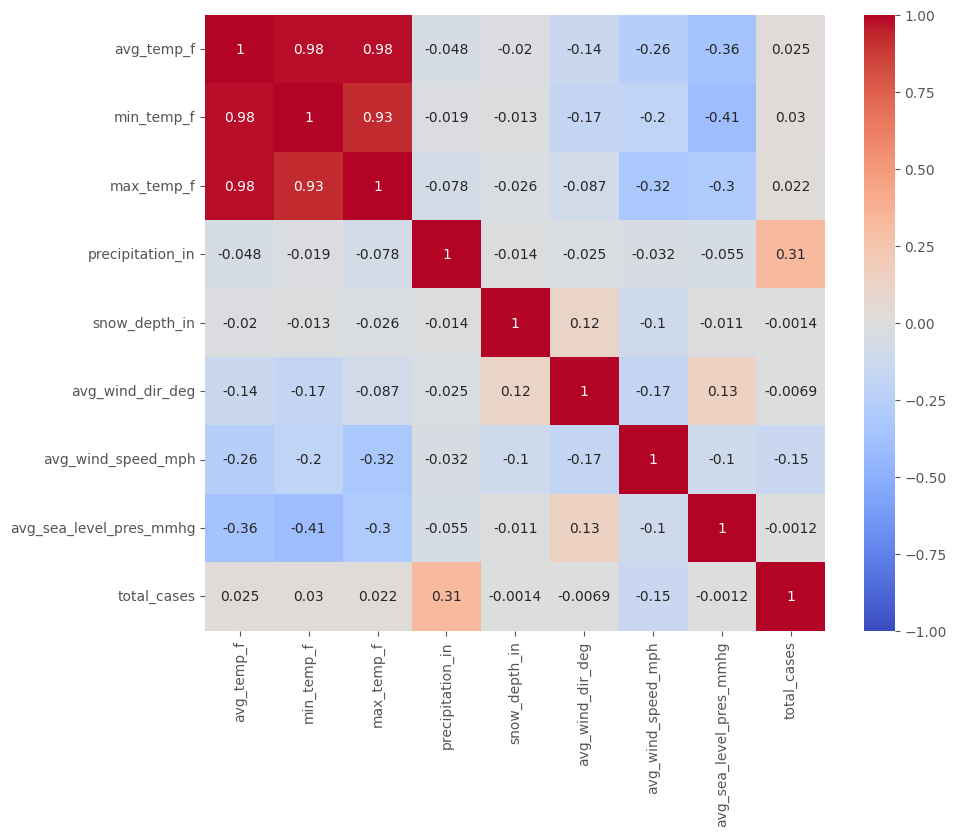

In [200]:
weather_features = ['avg_temp_f', 'min_temp_f', 'max_temp_f', 'precipitation_in', 'snow_depth_in', 'avg_wind_dir_deg',\
                     'avg_wind_speed_mph', 'avg_sea_level_pres_mmhg', 'total_cases']
correlation_matrix_weather = migraine_weather[weather_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_weather, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.show()

## 2.7 Summary

At this point, we have performed a comprehensive data cleaning and preprocessing operation. This has involved everything from checking for data consistency, to handling missing values, to merging and integrating various data sets. The data is now in a state that is amenable to further analysis and modeling. This notebook has set the stage for the exploration and insights that will be obtained in the subsequent notebooks.

## 2.8 Next Steps

The next step in the project pipeline is data analysis [03_data_analysis.ipynb](03_data_analysis.ipynb). In this notebook, we will explore the relationships between different variables and carry out statistical tests to validate the hypotheses.